# Setting Learning Rate Optimally for Gradient Descent using Keras

In this notebook we explore various techniques to set the learning rate of the Gradient descent algorithm for training Artificial Neural Networks (ANNs). Our goal is to introduce the broad category of approaches as well as to gain a comparative understanding.

We experiment with three aproaches to set learning rates.

- Experiment 1: Constant learning rate for Stochastic Gradient Descent (SGD) 
- Experiment 2: Learning rate schedule for SGD
- Experiment 3: Adaptive learning rates using extensions of SGD (fast optimizers) 


For experimentation, we build a Multi-Layer Perceptron (MLP) using Keras to classify MNIST handwritten digits dataset. We create a shallow ANN with just two hidden layers to perform classification. Since it's a shallow network, the convergence issue due to non-optimal learning rate would not be as severe as it is in deep ANNs or DNNs. As a result, we might not observe any benefits of using fast optimizers. Thus, we should treat the ensuing experiments only for illustrative purpose. In the context of DNNs, we will see completely different performance (superior) of the adaptive learning rate based approach.

It's a long notebook as we explore total 16 techniques. At the end we compare these techniques based on their validation and test accuracy, as well as number of epochs required for convergence.

See the following notebook for a brief introduction to the convergence problem in the Gradient Descent algorithm in Deep ANNs and motivation for various optimizers: https://github.com/rhasanbd/Multi-Layer-Perceptron-Curious-Dabbling/blob/master/MLP-II-Nonlinear%20Data%20%26%20Multi-Layer%20Perceptron.ipynb

In [1]:
import warnings
import os
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score 

import tensorflow as tf
from tensorflow import keras

## Load the Dataset


We load the train and test dataset using Keras. The Keras loading function loads every image as 28 × 28 pixel matrix (rather than a 1D array of size 784). Thus, the shapes of the training and testing dataset are: (60000, 28, 28) & (10000, 28, 28)

For training the ANN model, we flatten the input images that creates 1D array for each image.

Finally, we create validation dataset and scale all data.

In [2]:
mnist = keras.datasets.mnist

(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

# Flatten the features to create 1D array for each image
X_train_full = X_train_full.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)


# Create validation dataset as well as scale the data
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.0

print("No. of Training Samples: ", X_train.shape)
print("No. of Training Labels: ", y_train.shape)

print("\nNo. of Validation Samples: ", X_valid.shape)
print("No. of Validation Labels: ", y_valid.shape)

print("\nNo. of Testing Samples: ", X_test.shape)
print("No. of Testing Labels: ", y_test.shape)

print("\nX type: ", X_train.dtype)
print("y type: ", y_train.dtype)

No. of Training Samples:  (55000, 784)
No. of Training Labels:  (55000,)

No. of Validation Samples:  (5000, 784)
No. of Validation Labels:  (5000,)

No. of Testing Samples:  (10000, 784)
No. of Testing Labels:  (10000,)

X type:  float64
y type:  uint8


## Experiment 1: Constant Learning Rate for SGD


In experiment 1 we present two approaches:
- a) Constant Learning Rate for SGD
- b) Momentum infused Constant Learning Rate for SGD



Constant learning rate is the default learning rate schedule in SGD optimizer in Keras. Momentum is set to zero by default. 


#### Heuristic to Find Optimal Constant Learning Rate
It's tricky to choose the right learning rate. Thus, we perform the following experiment to find **an optimal constant learning rate**.

        To find an optimal constant learing rate we train the network for one epoch and grow the learning rate at each iteration. Then, by observing the change in loss at each iteration we find the optimal learning rate.

To increase the learning rate by a constant factor we define the following class.

In [44]:
'''
A class to increase the learning rate by a "factor" at each iteration.
It stores the changing learning rate and loss at each iteration.
'''

K = keras.backend

class IncreaseLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)
        
        
'''
Function to determine the "factor" to be used in the IncreaseLearningRate (above) object
'''
def computeFactorForIncreasingLearningRate(X, size_mini_batch, no_of_epochs, upper_bound_lr, lower_bound_lr):
    
    # Total number of iterations
    iterations = len(X) // size_mini_batch * no_of_epochs
    
    factor = np.exp(np.log(upper_bound_lr / lower_bound_lr) / iterations)
    
    return factor

### Experiment 1 (a): Finding an Optimal Constant Learning Rate for SGD

We build a shallow ANN, i.e., a MLP classifier with two hidden layers using Keras. We use the SGD optimizer.

Then, we create an IncreaseLearningRate object (class defined above). It increases the learning rate by 0.5% at each iteration. We pass this object as a callback to the fit() method of the model.

We start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration. Then, using a loss vs. learning rate plot we find the optimal constant learning rate.

In [4]:
'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
- First Layer: It instantiates an input tensor for buildng the model 
- Hidden Layers: Dense hidden layer with the ReLU activation function
- Output Layer: Dense output layer with 10 neurons.
                Since it's a multi-class classification, we use "softmax"  
                activation function in the output layer. 
'''
model = keras.models.Sequential([
    keras.Input(shape=(784,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

     
# Define the optimizer
optimizer=keras.optimizers.SGD(learning_rate=1e-3)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

'''
Create an IncreaseLearningRate object.
It increases the learning rate by 0.5% at each iteration:
We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration.
'''
increase_lr = IncreaseLearningRate(factor=1.005)


history = model.fit(X_train, y_train, 
                    batch_size=32, # batch size 32 is default
                    epochs=1,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[increase_lr])

Train on 55000 samples, validate on 5000 samples
55000/55000 [==============================] - 5s 86us/sample - loss: nan - accuracy: 0.5764 - val_loss: nan - val_accuracy: 0.0958


### Experiment 1: Plot the Loss as a Function of the Learning Rate

To create the plot for learning rate vs loss, we consider two things.

1. Since the increase in loss is much higher for larger learning rates, the plot will be skewed toward max_lr. The difference in loss for smaller learning rates will be compressed, hence difficult to distinguish. That's why we use log scale for the learning rate (i.e., log scale for x-axis).

        To implement the log scale, we use two things:
    
            -- The gcf() function to get the current Axes instance on the current figure matching the given keyword args.
            -- The Axes.set_xscale function to change the scale after the Axes object is created.


2. The upper limit of the y-axis (loss) need to be set carefully. If we use the maximum loss as the upper limit, then again the plot will be skewed. Since initially (for the min_lr) loss is reasonably large, but not as large as it is for max_lr, we can use the loss at min_lr to be the upper limit for y-axis. We tweak it a little bit for more clarity.

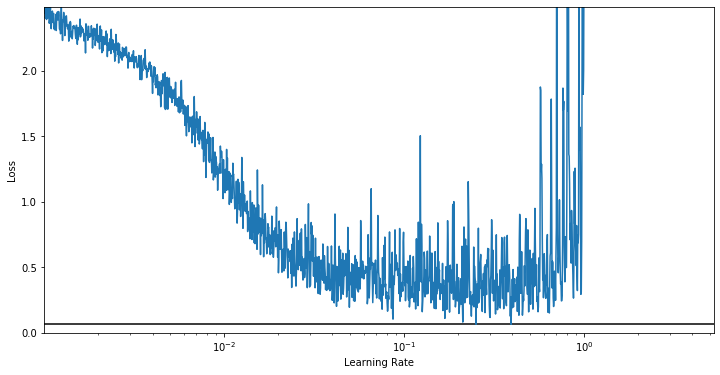

In [19]:
plt.figure(figsize = (12,6))
plt.plot(increase_lr.rates, increase_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(increase_lr.losses), min(increase_lr.rates), max(increase_lr.rates))
plt.xlim(min(increase_lr.rates), max(increase_lr.rates)) 
plt.ylim(0, increase_lr.losses[0])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()


### Observation:

We see that the loss starts increasing after 0.1. Thus, we use 0.1 as our optimal constant learning rate.

#### Function For Generating Learning Curves (Accuracy & Loss)

In [6]:
def plot_learning_curves(history, numOfEpochs, title):
    plt.figure(figsize=(18,6))

    plt.subplot(121)
    plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
    plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
    plt.legend(loc=0)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([1,numOfEpochs])
    plt.grid(True)
    plt.title("Model Accuracy: "+title)
    
    plt.subplot(122)
    plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
    plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
    plt.legend(loc=0)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([1,numOfEpochs])
    plt.grid(True)
    plt.title("Model Loss: "+title)
    
    plt.show() 

### Experiment 1 (a): Training using the Optimal Constant Learning Rate for SGD

In [17]:
%%time

keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.Input(shape=(784,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])


optimizer=keras.optimizers.SGD(learning_rate=0.1)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


# Create a callback object of early stopping
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

# Train the model
history_constant_lrate = model.fit(X_train, y_train, 
                    batch_size=32, # batch size 32 is default
                    epochs=100,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 4s 75us/sample - loss: 0.2713 - accuracy: 0.9188 - val_loss: 0.1140 - val_accuracy: 0.9694
Epoch 2/100
55000/55000 [==============================] - 3s 63us/sample - loss: 0.1105 - accuracy: 0.9667 - val_loss: 0.0862 - val_accuracy: 0.9764
Epoch 3/100
55000/55000 [==============================] - 4s 65us/sample - loss: 0.0756 - accuracy: 0.9770 - val_loss: 0.0768 - val_accuracy: 0.9766
Epoch 4/100
55000/55000 [==============================] - 4s 65us/sample - loss: 0.0540 - accuracy: 0.9833 - val_loss: 0.0708 - val_accuracy: 0.9794
Epoch 5/100
55000/55000 [==============================] - 3s 63us/sample - loss: 0.0401 - accuracy: 0.9876 - val_loss: 0.0729 - val_accuracy: 0.9786
Epoch 6/100
55000/55000 [==============================] - 4s 65us/sample - loss: 0.0305 - accuracy: 0.9907 - val_loss: 0.0780 - val_accuracy: 0.9818
Epoch 7/100
55000/55000 [==========================

### Experiment 1 (a): Evaluate the Constant Learning Rate based Model

The "numOfEpochs" parameter should be set based on the number of epochs at which the training stopped (due to early stopping).

Epochs:  23
Constant Learning Rate - Train Accuracy:  0.9999273
Constant Learning Rate - Test Accuracy:  0.9813

Constant Learning Rate - Train Loss:  0.0015110199564922367
Constant Learning Rate - Test Loss:  0.06696832454066576


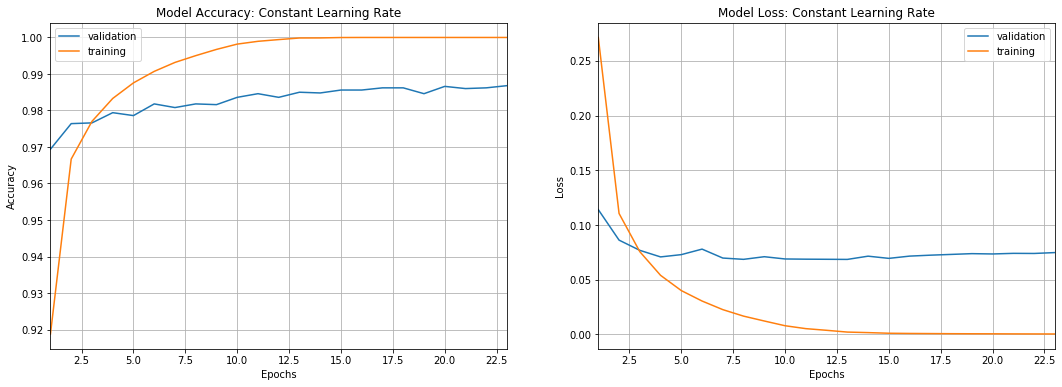

In [18]:
numOfEpochs_constant_lrate = len(history_constant_lrate.history['loss'])
print("Epochs: ", numOfEpochs_constant_lrate)

train_loss_constant_lrate = model.evaluate(X_train, y_train, verbose=0)[0]
train_accuracy_constant_lrate = model.evaluate(X_train, y_train, verbose=0)[1]

test_loss_constant_lrate = model.evaluate(X_test, y_test, verbose=0)[0]
test_accuracy_constant_lrate = model.evaluate(X_test, y_test, verbose=0)[1]

print("Constant Learning Rate - Train Accuracy: ", train_accuracy_constant_lrate)
print("Constant Learning Rate - Test Accuracy: ", test_accuracy_constant_lrate)

print("\nConstant Learning Rate - Train Loss: ", train_loss_constant_lrate)
print("Constant Learning Rate - Test Loss: ", test_loss_constant_lrate)

plot_learning_curves(history_constant_lrate, numOfEpochs_constant_lrate, "Constant Learning Rate")

## Experiment 1 (b): Momentum infused Constant Learning Rate for SGD

- What is momentum?

The SGD algorithm tries to find the global minimum by adapting the weights. The loss function typically has a highly non-linear dependence on the weights and bias parameters. Due to the non-convex nature of the loss function, in practice, multiple local minima may exist. Hence, there will be many points in the weight space at which the gradient vanishes (or is numerically very small).

Example of such places are: local minimum, saddle point and plateau. At these area, the gradient on every dimension (direction) "vanishes" and the weight update becomes extremely slow. At the worst case, the model stops training and returns the "optimized" weights.


The local minima, saddle points and plateau areas stall the training. There are other types of regions that can slow down the training significanty. The SGD algorithm itself is unable to guarantee faster convergence. Thus, to expedite the training time for converging to the near-global optimum we need to use fast optimizers.

A simple technique is to augment constant learning rate SGD with momentum. See the following notebook for a motivating discussion on momentum optimization:
https://github.com/rhasanbd/Multi-Layer-Perceptron-Curious-Dabbling/blob/master/MLP-II-Nonlinear%20Data%20%26%20Multi-Layer%20Perceptron.ipynb

Below we use a fixed value of momentum based on hyperparameter tuning reported in the following notebook:
https://github.com/rhasanbd/Smooth-Taste-of-Keras--Journey-Through-MLPs/blob/master/Keras-MLP%20Classifier-2-Hyperparameter%20Tuning.ipynb

In [15]:
%%time

keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

model_momentum = keras.models.Sequential([
    keras.Input(shape=(784,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])


optimizer=keras.optimizers.SGD(learning_rate=0.1, momentum=0.1)


model_momentum.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)


history_constant_lrate_momentum = model_momentum.fit(X_train, y_train, 
                    batch_size=32, # batch size 32 is default
                    epochs=100,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 4s 75us/sample - loss: 0.2632 - accuracy: 0.9202 - val_loss: 0.1111 - val_accuracy: 0.9692
Epoch 2/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.1068 - accuracy: 0.9677 - val_loss: 0.0842 - val_accuracy: 0.9774
Epoch 3/100
55000/55000 [==============================] - 4s 67us/sample - loss: 0.0725 - accuracy: 0.9775 - val_loss: 0.0775 - val_accuracy: 0.9770
Epoch 4/100
55000/55000 [==============================] - 4s 69us/sample - loss: 0.0510 - accuracy: 0.9837 - val_loss: 0.0729 - val_accuracy: 0.9786
Epoch 5/100
55000/55000 [==============================] - 4s 67us/sample - loss: 0.0375 - accuracy: 0.9887 - val_loss: 0.0680 - val_accuracy: 0.9808
Epoch 6/100
55000/55000 [==============================] - 4s 67us/sample - loss: 0.0281 - accuracy: 0.9914 - val_loss: 0.0744 - val_accuracy: 0.9814
Epoch 7/100
55000/55000 [==========================

Epochs:  19
Constant Learning Rate with Momentum - Train Accuracy:  0.9992727
Constant Learning Rate with Momentum - Test Accuracy:  0.9832

Constant Learning Rate with Momentum - Train Loss:  0.005108292749064805
Constant Learning Rate with Momentum - Test Loss:  0.06106927128024836


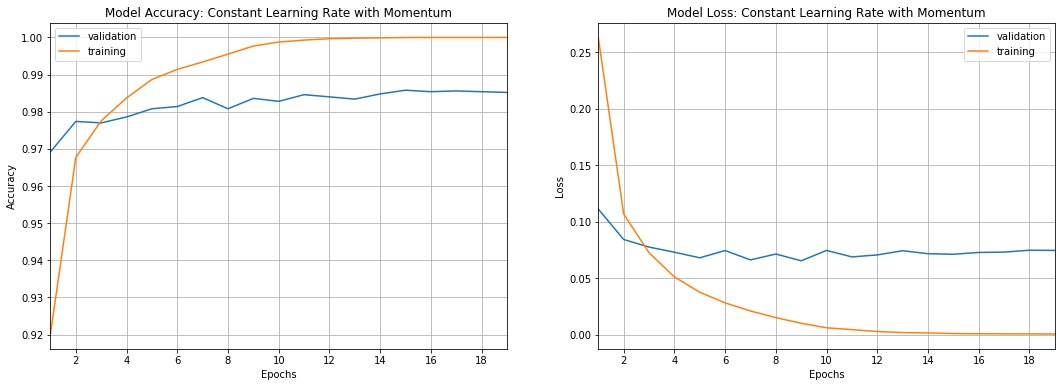

In [16]:
numOfEpochs_constant_lrate_momentum = len(history_constant_lrate_momentum.history['loss'])
print("Epochs: ", numOfEpochs_constant_lrate_momentum)

train_loss_constant_lrate_momentum = model_momentum.evaluate(X_train, y_train, verbose=0)[0]
train_accuracy_constant_lrate_momentum = model_momentum.evaluate(X_train, y_train, verbose=0)[1]

test_loss_constant_lrate_momentum = model_momentum.evaluate(X_test, y_test, verbose=0)[0]
test_accuracy_constant_lrate_momentum = model_momentum.evaluate(X_test, y_test, verbose=0)[1]

print("Constant Learning Rate with Momentum - Train Accuracy: ", train_accuracy_constant_lrate_momentum)
print("Constant Learning Rate with Momentum - Test Accuracy: ", test_accuracy_constant_lrate_momentum)

print("\nConstant Learning Rate with Momentum - Train Loss: ", train_loss_constant_lrate_momentum)
print("Constant Learning Rate with Momentum - Test Loss: ", test_loss_constant_lrate_momentum)

plot_learning_curves(history_constant_lrate_momentum, numOfEpochs_constant_lrate_momentum, "Constant Learning Rate with Momentum")

## Experiment 2: Learning Rate Schedule for SGD


The training has two goals:
- Reach the global minimum (or a good local minimum) 
- Reach there as fast as possible

Thus, initially we could set the learning rate at a large value so that we could reach toward the valley faster. It helps to make quick progress and escape local minima. Then, as we approach the valley we reduce it slowly so that it converges to the global minimum. 

To accomplish this, we define a function that determines the learning rate at each iteration. It is called the **learning schedule**.

Defining a good learning schedule is tricky. Because:
- If the learning rate is reduced too slowly, we may get stuck in a local minimum, or even end up frozen halfway to the minimum. 
- If the learning rate is reduced too quickly, we may jump around the minimum for a long time and end up with a suboptimal solution if we halt training too early.

Thus, we explore 9 different learning schedules and see how they perform.
- a) Step Decay
- b) Piecewise Constant Decay
- c) Exponential Decay
- d) Exponential Decay (variant)
- e) Time-based Decay
- f) Time-based Decay (Keras implementation)
- g) Performance-based Decay (implemented by Keras' ReduceLROnPlateau callback class)
- h) Cyclical Learning Rate
- i) One Cycle Learning

The last two techniques **fundamentally differ** from the rest of the learning schedules. Instead of decresing the learning rate from its initial larger value, these two techniques vary the learning rate in a cyclic fashion. They are both efficient (converges faster) and effective (generalizes better). Thus, we will emphasize more on these techniques.


## Experiment 2 (a): Step Decay Learning Schedule

Step decay schedule drops the learning rate by a factor every few epochs. 

The mathematical form of step decay is :

- $lr = lr_0 * drop^{floor(\frac{epochs}{ epochs\_drop})} $

A simple heuristic is to drop the learning rate by half every 10 epochs. 

First, we define the step decay function.

Then, we pass it as an argument of the **LearningRateScheduler callback**: https://keras.io/api/callbacks/learning_rate_scheduler/

At the beginning of every epoch, the learning rate scheduler callback gets the updated learning rate value from the learning rate schedule function (e.g., step decay function), with the current number of epochs and current learning rate (2nd argument of the learning schedule function), and applies the updated learning rate on the optimizer.


Also, we define a class to store the changing loss and learning rates at each epoch.

In [20]:
def step_decay(epochs, lr):
    initial_lrate = lr
    drop = 0.5
    epochs_drop = 10
    lrate = initial_lrate * math.pow(drop, math.floor((1+epochs)/epochs_drop))
    
    return lrate


# A class to store the changing loss and learning rates at each epoch.
class LossHistory_StepDecay(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses), self.model.optimizer.lr))

### Function to Plot Learning Rate & Momentum

In [21]:
# plot learning rate & momentum
def plot_learning_rate(loss_history_lschedule, numOfEpochs, title, momentumPlot=False):
    plt.figure(figsize=(10,6))
    plt.plot(range(1,numOfEpochs+1),loss_history_lschedule.lr,label='learning rate')
    plt.xlabel("Epoch")
    plt.xlim([1,numOfEpochs+1])
    plt.ylabel("Learning rate")
    
    if(momentumPlot==True):
        plt.plot(range(1,numOfEpochs+1),loss_history_lschedule.mom,'r-', label='momentum')
        plt.ylabel("Learning rate & Momentum")
    
    
    plt.legend(loc=0)
    plt.grid(True)
    plt.title(title)
    plt.show()

### Experiment 2 (a): Training using Step Decay Learning Schedule

In [22]:
%%time

keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

model_step_decay = keras.models.Sequential([
    keras.Input(shape=(784,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])


optimizer=keras.optimizers.SGD(learning_rate=1e-1, momentum=0.1)


model_step_decay.compile(loss="sparse_categorical_crossentropy",
                         optimizer=optimizer,
                         metrics=["accuracy"])


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

loss_history_step_decay_cb = LossHistory_StepDecay()

lschedule_step_decay_cb = keras.callbacks.LearningRateScheduler(step_decay, verbose=1)


history_step_decay = model_step_decay.fit(X_train, y_train, 
                               batch_size=32, # batch size 32 is default
                               epochs=100,
                               verbose=1,
                               validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, loss_history_step_decay_cb, lschedule_step_decay_cb])

Train on 55000 samples, validate on 5000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 1/100
55000/55000 [==============================] - 4s 78us/sample - loss: 0.2632 - accuracy: 0.9202 - val_loss: 0.1111 - val_accuracy: 0.9692

Epoch 00002: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 2/100
55000/55000 [==============================] - 4s 66us/sample - loss: 0.1068 - accuracy: 0.9677 - val_loss: 0.0842 - val_accuracy: 0.9774

Epoch 00003: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 3/100
55000/55000 [==============================] - 4s 67us/sample - loss: 0.0725 - accuracy: 0.9775 - val_loss: 0.0775 - val_accuracy: 0.9770

Epoch 00004: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 4/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.0510 - accuracy: 0.9837 - val_loss: 0.0729 - val_accuracy: 0.9786

Epoch 00005: Learn

### Experiment 2 (a): Evaluate using Step Decay Learning Schedule

Epochs:  22
Step Decay - Train Accuracy:  0.99994546
Step Decay - Test Accuracy:  0.9843

Step Decay - Train Loss:  0.0019597146637028674
Step Decay - Test Loss:  0.05966613053493966


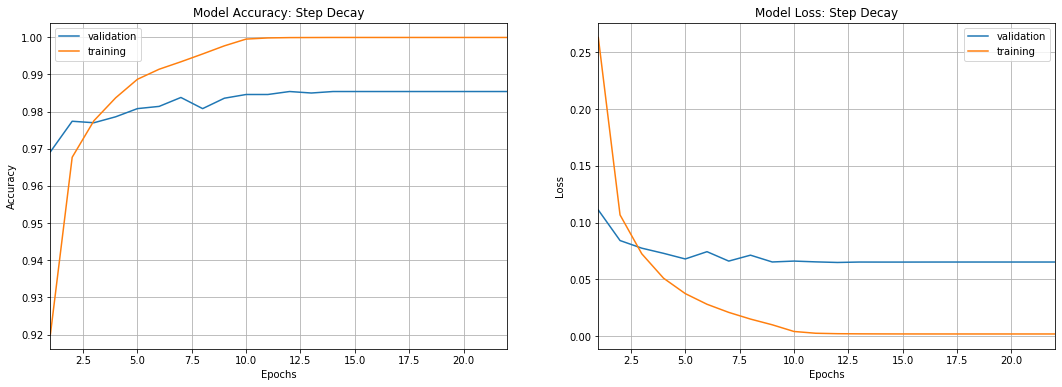

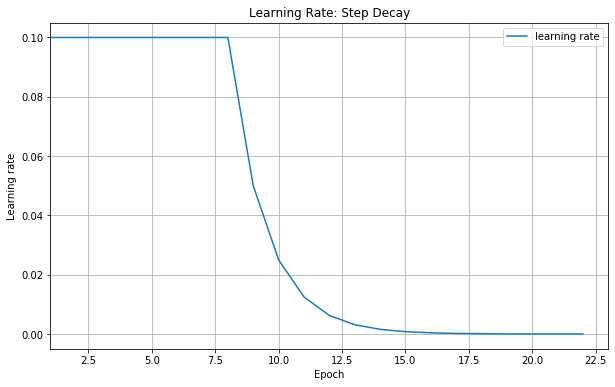

In [23]:
numOfEpochs_step_decay = len(history_step_decay.history['loss'])
print("Epochs: ", numOfEpochs_step_decay)

train_loss_step_decay = model_step_decay.evaluate(X_train, y_train, verbose=0)[0]
train_accuracy_step_decay = model_step_decay.evaluate(X_train, y_train, verbose=0)[1]

test_loss_step_decay = model_step_decay.evaluate(X_test, y_test, verbose=0)[0]
test_accuracy_step_decay = model_step_decay.evaluate(X_test, y_test, verbose=0)[1]

print("Step Decay - Train Accuracy: ", train_accuracy_step_decay)
print("Step Decay - Test Accuracy: ", test_accuracy_step_decay)

print("\nStep Decay - Train Loss: ", train_loss_step_decay)
print("Step Decay - Test Loss: ", test_loss_step_decay)

plot_learning_curves(history_step_decay, numOfEpochs_step_decay, "Step Decay")

plot_learning_rate(loss_history_step_decay_cb, numOfEpochs_step_decay, "Learning Rate: Step Decay")

## Experiment 2 (b): Piecewise Constant Learning Schedule

In this schedule, we keep the learning rate constant for a number of epochs, then reduce it by a factor and keep it constant for another number of epochs, and so on. 

The main challenge with this scheduling technique is that it requires finding out the right sequence of learning rates and the number of epochs to use each of them.

In [24]:
def piecewise_constant(epoch, lr): 
    initial_lrate = lr   
    
    if (epoch < 5):
        lrate = initial_lrate 
    
    elif (epoch < 15):
        lrate = initial_lrate*0.05  
       
    else:
        lrate = initial_lrate*0.01 
        
    return lrate
    

# A class to store the changing loss and learning rates at each epoch.
class LossHistory_PiecewiseConstant(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(piecewise_constant(len(self.losses), self.model.optimizer.lr))

### Experiment 2 (b): Training using Piecewise Constant Learning Schedule

In [25]:
%%time

keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

model_piecewise_constant = keras.models.Sequential([
    keras.Input(shape=(784,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])


optimizer=keras.optimizers.SGD(learning_rate=1e-1, momentum=0.1)


model_piecewise_constant.compile(loss="sparse_categorical_crossentropy",
                         optimizer=optimizer,
                         metrics=["accuracy"])


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

loss_history_piecewise_constant_cb = LossHistory_PiecewiseConstant()


lschedule_piecewise_constant_cb = keras.callbacks.LearningRateScheduler(piecewise_constant, verbose=1)


history_piecewise_constant = model_piecewise_constant.fit(X_train, y_train, 
                               batch_size=32, # batch size 32 is default
                               epochs=100,
                               verbose=1,
                               validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, loss_history_piecewise_constant_cb, 
                               lschedule_piecewise_constant_cb])

Train on 55000 samples, validate on 5000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 1/100
55000/55000 [==============================] - 4s 76us/sample - loss: 0.2632 - accuracy: 0.9202 - val_loss: 0.1111 - val_accuracy: 0.9692

Epoch 00002: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 2/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.1068 - accuracy: 0.9677 - val_loss: 0.0842 - val_accuracy: 0.9774

Epoch 00003: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 3/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.0725 - accuracy: 0.9775 - val_loss: 0.0775 - val_accuracy: 0.9770

Epoch 00004: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 4/100
55000/55000 [==============================] - 4s 69us/sample - loss: 0.0510 - accuracy: 0.9837 - val_loss: 0.0729 - val_accuracy: 0.9786

Epoch 00005: Learn

### Experiment 2 (b): Evaluate using Piecewise Constant Learning Schedule

Epochs:  20
Step Decay - Train Accuracy:  0.9964909
Step Decay - Test Accuracy:  0.9814

Step Decay - Train Loss:  0.01612020696689036
Step Decay - Test Loss:  0.05927092195803998


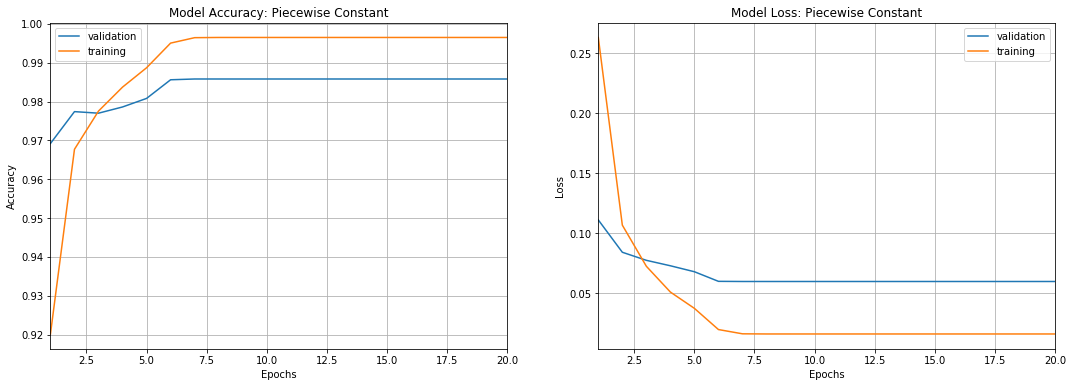

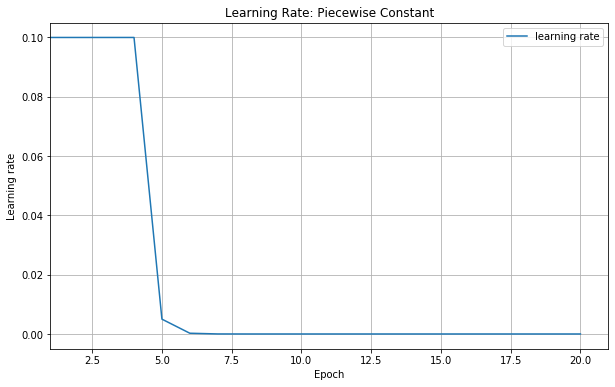

In [26]:
numOfEpochs_piecewise_constant = len(history_piecewise_constant.history['loss'])
print("Epochs: ", numOfEpochs_piecewise_constant)

train_loss_piecewise_constant = model_piecewise_constant.evaluate(X_train, y_train, verbose=0)[0]
train_accuracy_piecewise_constant = model_piecewise_constant.evaluate(X_train, y_train, verbose=0)[1]

test_loss_piecewise_constant = model_piecewise_constant.evaluate(X_test, y_test, verbose=0)[0]
test_accuracy_piecewise_constant = model_piecewise_constant.evaluate(X_test, y_test, verbose=0)[1]

print("Step Decay - Train Accuracy: ", train_accuracy_piecewise_constant)
print("Step Decay - Test Accuracy: ", test_accuracy_piecewise_constant)

print("\nStep Decay - Train Loss: ", train_loss_piecewise_constant)
print("Step Decay - Test Loss: ", test_loss_piecewise_constant)

plot_learning_curves(history_piecewise_constant, numOfEpochs_piecewise_constant, "Piecewise Constant")

plot_learning_rate(loss_history_piecewise_constant_cb, 
                   numOfEpochs_piecewise_constant, "Learning Rate: Piecewise Constant")                   

## Experiment 2 (c): Exponential Decay Learning Schedule

The mathematical form of exponential decay is:

- $lr = lr_0 * e^{−k*epochs}$

Here $k$ is the **only hyperparameter, which makes this a feasible schedule**.

In [27]:
def exp_decay(epochs, lr):
    initial_lrate = lr
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epochs)
    return lrate


# A class to store the changing loss and learning rates at each epoch.
class LossHistory_ExpDecay(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(len(self.losses), self.model.optimizer.lr))

### Experiment 2 (c): Training using Exponential Decay Learning Schedule

In [28]:
%%time

keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

model_exp_decay = keras.models.Sequential([
    keras.Input(shape=(784,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])


optimizer=keras.optimizers.SGD(learning_rate=1e-1, momentum=0.1)


model_exp_decay.compile(loss="sparse_categorical_crossentropy",
                         optimizer=optimizer,
                         metrics=["accuracy"])


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

loss_history_exp_decay_cb = LossHistory_ExpDecay()

lschedule_exp_decay_cb = keras.callbacks.LearningRateScheduler(exp_decay, verbose=1)


history_exp_decay = model_exp_decay.fit(X_train, y_train, 
                               batch_size=32, # batch size 32 is default
                               epochs=100,
                               verbose=1,
                               validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, loss_history_exp_decay_cb, lschedule_exp_decay_cb])

Train on 55000 samples, validate on 5000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 1/100
55000/55000 [==============================] - 4s 77us/sample - loss: 0.2632 - accuracy: 0.9202 - val_loss: 0.1111 - val_accuracy: 0.9692

Epoch 00002: LearningRateScheduler reducing learning rate to 0.09048374315190877.
Epoch 2/100
55000/55000 [==============================] - 4s 67us/sample - loss: 0.1047 - accuracy: 0.9683 - val_loss: 0.0842 - val_accuracy: 0.9764

Epoch 00003: LearningRateScheduler reducing learning rate to 0.07408182056868164.
Epoch 3/100
55000/55000 [==============================] - 4s 67us/sample - loss: 0.0678 - accuracy: 0.9792 - val_loss: 0.0769 - val_accuracy: 0.9780

Epoch 00004: LearningRateScheduler reducing learning rate to 0.05488116446995039.
Epoch 4/100
55000/55000 [==============================] - 4s 67us/sample - loss: 0.0444 - accuracy: 0.9866 - val_loss: 0.0686 - val_accuracy: 0.9812

Epoch 00005: Learn

### Experiment 2 (c): Evaluate using Exponential Decay Learning Schedule

Epochs:  20
Exponential Decay - Train Accuracy:  0.99707276
Exponential Decay - Test Accuracy:  0.9812

Exponential Decay - Train Loss:  0.016329389887616376
Exponential Decay - Test Loss:  0.0594958289390197


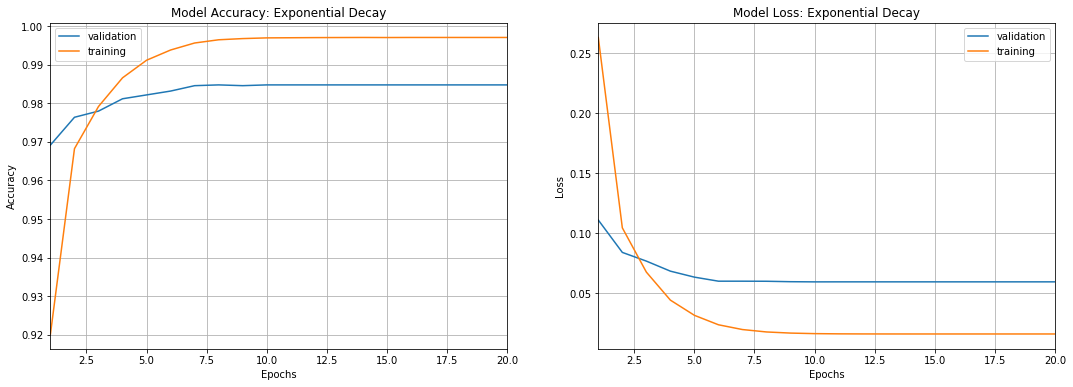

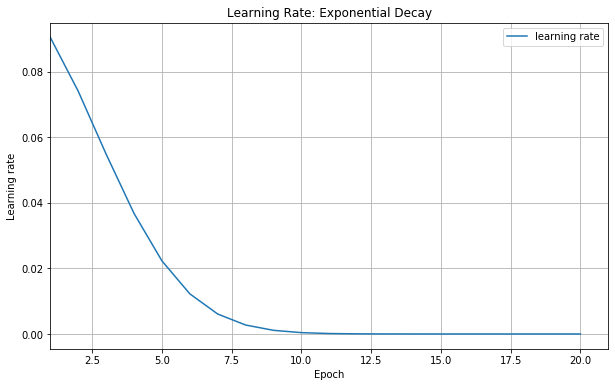

In [29]:
numOfEpochs_exp_decay = len(history_exp_decay.history['loss'])
print("Epochs: ", numOfEpochs_exp_decay)

train_loss_exp_decay = model_exp_decay.evaluate(X_train, y_train, verbose=0)[0]
train_accuracy_exp_decay = model_exp_decay.evaluate(X_train, y_train, verbose=0)[1]

test_loss_exp_decay = model_exp_decay.evaluate(X_test, y_test, verbose=0)[0]
test_accuracy_exp_decay = model_exp_decay.evaluate(X_test, y_test, verbose=0)[1]

print("Exponential Decay - Train Accuracy: ", train_accuracy_exp_decay)
print("Exponential Decay - Test Accuracy: ", test_accuracy_exp_decay)

print("\nExponential Decay - Train Loss: ", train_loss_exp_decay)
print("Exponential Decay - Test Loss: ", test_loss_exp_decay)


plot_learning_curves(history_exp_decay, numOfEpochs_exp_decay, "Exponential Decay")

plot_learning_rate(loss_history_exp_decay_cb, numOfEpochs_exp_decay, "Learning Rate: Exponential Decay")

## Experiment 2 (d): Exponential Decay Learning Schedule (Variant)


A variant of exponential decay learning schedule can be defined by reducing the learning rate by some factor after some steps.

The mathematical form of this variant is:

- $lr = lr_0 * k^{epochs/s}$


The $k$ and $s$ are two hyperparameters. The learning rate will gradually decay by a factor of $k$ every $s$ steps. So, if $s = 20$, then after every 20 epochs the learning rate will be decayed by a factor of $k$.

Usually the value of $k$ is set to 0.1. For this experiment, $s$ is set to 20.

This implementation updates learning rate after **every epoch**. We can tweak this to do the update at each iteration.

In [30]:
def exp_decay_variant(epochs, lr):
    initial_lrate = lr
    k = 0.1
    s = 20
    lrate = initial_lrate * k**(epochs / s)
    return lrate



# A class to store the changing loss and learning rates at each epoch.
class LossHistory_ExpDecayVariant(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay_variant(len(self.losses), self.model.optimizer.lr))

### Experiment 2 (d): Training using Exponential Decay Learning Schedule (variant)

In [31]:
%%time

keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

model_exp_decay_variant = keras.models.Sequential([
    keras.Input(shape=(784,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])


optimizer=keras.optimizers.SGD(learning_rate=1e-1, momentum=0.1)


model_exp_decay_variant.compile(loss="sparse_categorical_crossentropy",
                         optimizer=optimizer,
                         metrics=["accuracy"])


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

loss_history_exp_decay_variant_cb = LossHistory_ExpDecayVariant()

lschedule_exp_decay_variant_cb = keras.callbacks.LearningRateScheduler(exp_decay_variant, verbose=1)


history_exp_decay_variant = model_exp_decay_variant.fit(X_train, y_train, 
                               batch_size=32, # batch size 32 is default
                               epochs=100,
                               verbose=1,
                               validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, loss_history_exp_decay_variant_cb, 
                               lschedule_exp_decay_variant_cb])

Train on 55000 samples, validate on 5000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 1/100
55000/55000 [==============================] - 4s 73us/sample - loss: 0.2632 - accuracy: 0.9202 - val_loss: 0.1111 - val_accuracy: 0.9692

Epoch 00002: LearningRateScheduler reducing learning rate to 0.08912509514144194.
Epoch 2/100
55000/55000 [==============================] - 4s 67us/sample - loss: 0.1043 - accuracy: 0.9685 - val_loss: 0.0849 - val_accuracy: 0.9762

Epoch 00003: LearningRateScheduler reducing learning rate to 0.07079458080914086.
Epoch 3/100
55000/55000 [==============================] - 4s 70us/sample - loss: 0.0670 - accuracy: 0.9796 - val_loss: 0.0757 - val_accuracy: 0.9778

Epoch 00004: LearningRateScheduler reducing learning rate to 0.050118726143913175.
Epoch 4/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.0439 - accuracy: 0.9871 - val_loss: 0.0678 - val_accuracy: 0.9814

Epoch 00005: Lear

### Experiment 2 (d): Evaluate using Exponential Decay Learning Schedule (variant)

Epochs:  20
Exponential Decay - Train Accuracy:  0.9964
Exponential Decay - Test Accuracy:  0.9809

Exponential Decay - Train Loss:  0.018399541398849
Exponential Decay - Test Loss:  0.06059557953074109


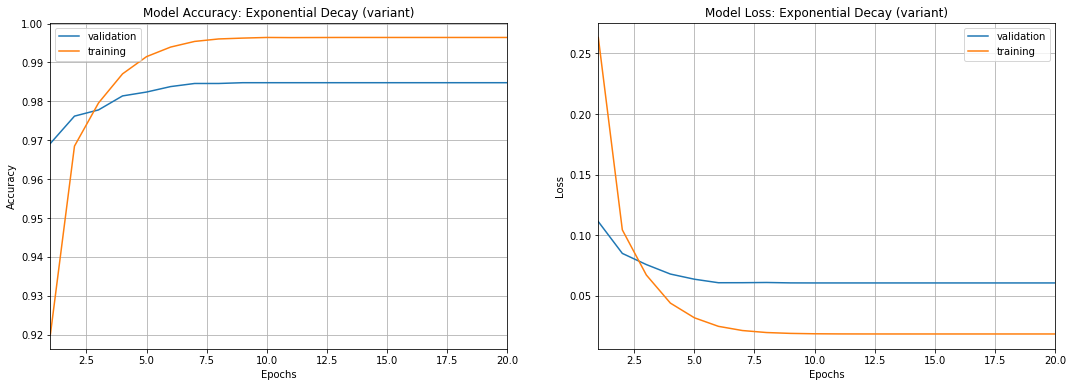

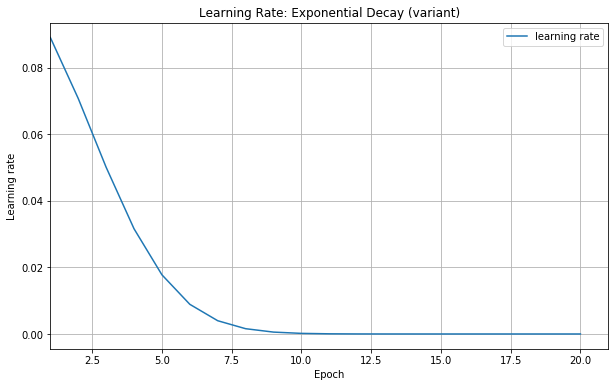

In [32]:
numOfEpochs_exp_decay_variant = len(history_exp_decay_variant.history['loss'])
print("Epochs: ", numOfEpochs_exp_decay_variant)

train_loss_exp_decay_variant = model_exp_decay_variant.evaluate(X_train, y_train, verbose=0)[0]
train_accuracy_exp_decay_variant = model_exp_decay_variant.evaluate(X_train, y_train, verbose=0)[1]

test_loss_exp_decay_variant = model_exp_decay_variant.evaluate(X_test, y_test, verbose=0)[0]
test_accuracy_exp_decay_variant = model_exp_decay_variant.evaluate(X_test, y_test, verbose=0)[1]

print("Exponential Decay - Train Accuracy: ", train_accuracy_exp_decay_variant)
print("Exponential Decay - Test Accuracy: ", test_accuracy_exp_decay_variant)

print("\nExponential Decay - Train Loss: ", train_loss_exp_decay_variant)
print("Exponential Decay - Test Loss: ", test_loss_exp_decay_variant)


plot_learning_curves(history_exp_decay_variant, numOfEpochs_exp_decay_variant, "Exponential Decay (variant)")

plot_learning_rate(loss_history_exp_decay_variant_cb, numOfEpochs_exp_decay_variant, 
                   "Learning Rate: Exponential Decay (variant)")

## Experiment 2 (e): Time-based Decay Learning Schedule


The mathematical form of time-based decay is: 

- $lr = \frac{lr_0}{(1 + epochs/s)^c}$ 

This schedule is taken from the following two references:
- https://leon.bottou.org/publications/pdf/compstat-2010.pdf
- https://arxiv.org/pdf/1107.2490.pdf

The initial learning rate $lr_0$, power $c$ and steps $s$ are hyperparameters. Here $c$ is a problem-dependent constant and is set to 1 for SGD and 0.75 to averaged SGD.


The learning rate **decays** after every step $s$. So, after the first $s$ steps, it is down to $lr_0/2$. Let's explain how. Suppose, $s = 20$. Then, after 20 epochs, $epochs/s = 1$. Hence, the learning rate would be decayed by $lr_0/2$. After next $s$ steps, it is decayed to $lr_0/3$, and so on. We see that the schedule first decays quickly, then more and more slowly. This schedule is also known as **power schedule**. 


To be consistent with the Keras implementation of time-based decay (or Power) schedule, we set $s = \frac{1}{decay}$ and $c = 1$:

- $lr = \frac{lr_0}{(1 + decay * epochs)}$ 


In [33]:
def time_based_decay(epochs, lr):
    initial_lrate = lr
    decay = 0.1    
    lrate = initial_lrate * (1.0 / (1.0 + decay * epochs))
    return lrate


# A class to store the changing loss and learning rates at each epoch.
class LossHistory_TimeBasedDecay(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(time_based_decay(len(self.losses), self.model.optimizer.lr))

### Experiment 2 (e): Training using Time-based Decay Learning Schedule

In [34]:
%%time

keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

model_time_based_decay = keras.models.Sequential([
    keras.Input(shape=(784,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])


optimizer=keras.optimizers.SGD(learning_rate=1e-1, momentum=0.1)


model_time_based_decay.compile(loss="sparse_categorical_crossentropy",
                         optimizer=optimizer,
                         metrics=["accuracy"])


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

loss_history_time_based_decay_cb = LossHistory_TimeBasedDecay()

lschedule_time_based_decay_cb = keras.callbacks.LearningRateScheduler(time_based_decay, verbose=1)


history_time_based_decay = model_time_based_decay.fit(X_train, y_train, 
                               batch_size=32, # batch size 32 is default
                               epochs=100,
                               verbose=1,
                               validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, loss_history_time_based_decay_cb, lschedule_time_based_decay_cb])

Train on 55000 samples, validate on 5000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 1/100
55000/55000 [==============================] - 4s 75us/sample - loss: 0.2632 - accuracy: 0.9202 - val_loss: 0.1111 - val_accuracy: 0.9692

Epoch 00002: LearningRateScheduler reducing learning rate to 0.09090909226374193.
Epoch 2/100
55000/55000 [==============================] - 4s 67us/sample - loss: 0.1049 - accuracy: 0.9682 - val_loss: 0.0841 - val_accuracy: 0.9764

Epoch 00003: LearningRateScheduler reducing learning rate to 0.07575757801532745.
Epoch 3/100
55000/55000 [==============================] - 4s 67us/sample - loss: 0.0679 - accuracy: 0.9792 - val_loss: 0.0777 - val_accuracy: 0.9766

Epoch 00004: LearningRateScheduler reducing learning rate to 0.05827506001179034.
Epoch 4/100
55000/55000 [==============================] - 4s 67us/sample - loss: 0.0449 - accuracy: 0.9863 - val_loss: 0.0688 - val_accuracy: 0.9812

Epoch 00005: Learn

### Experiment 2 (e): Evaluation using Time-based Decay Learning Schedule

Epochs:  20
Time-based Decay - Train Accuracy:  0.9978909
Time-based Decay - Test Accuracy:  0.9818

Time-based Decay - Train Loss:  0.014125963965380057
Time-based Decay - Test Loss:  0.059078281933249675


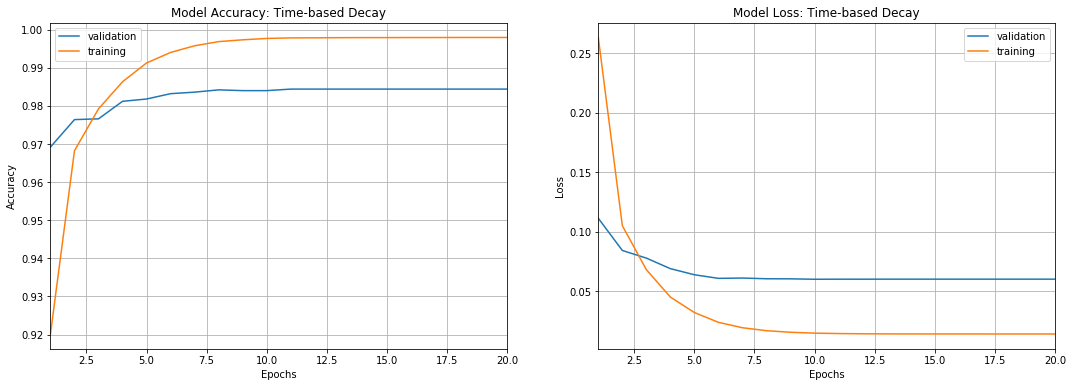

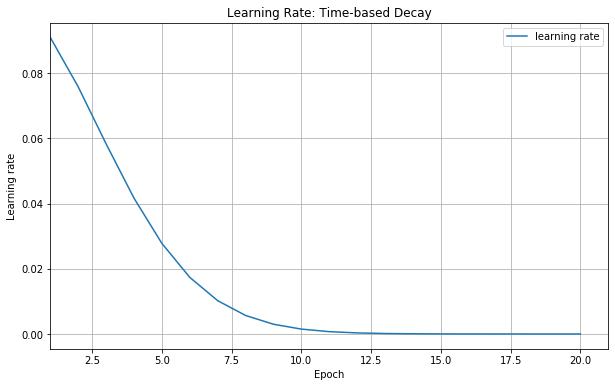

In [35]:
numOfEpochs_time_based_decay = len(history_time_based_decay.history['loss'])
print("Epochs: ", numOfEpochs_time_based_decay)

train_loss_time_based_decay = model_time_based_decay.evaluate(X_train, y_train, verbose=0)[0]
train_accuracy_time_based_decay = model_time_based_decay.evaluate(X_train, y_train, verbose=0)[1]

test_loss_time_based_decay = model_time_based_decay.evaluate(X_test, y_test, verbose=0)[0]
test_accuracy_time_based_decay = model_time_based_decay.evaluate(X_test, y_test, verbose=0)[1]

print("Time-based Decay - Train Accuracy: ", train_accuracy_time_based_decay)
print("Time-based Decay - Test Accuracy: ", test_accuracy_time_based_decay)

print("\nTime-based Decay - Train Loss: ", train_loss_time_based_decay)
print("Time-based Decay - Test Loss: ", test_loss_time_based_decay)


plot_learning_curves(history_time_based_decay, numOfEpochs_time_based_decay, "Time-based Decay")

plot_learning_rate(loss_history_time_based_decay_cb, numOfEpochs_time_based_decay, "Learning Rate: Time-based Decay")

## Experiment 2 (f): Time-based Decay Schedule (Keras)


The Keras library provides a time-based learning rate scheduler. It is controlled via the **decay** hyperparameter of the optimizer class (e.g., SGD, AdaGrad, Adam, etc.). So, we can use decay with every optimizer. By default, it is set to zero.

    optimizer = keras.optimizers.SGD(lr=0.1, decay=1e-4)


The mathematical form of Keras' time-based decay schedule is: 

- $lr = \frac{lr_0}{(1 + decay * iterations)}$ 

Here, $iterations = epochs * numberOfIterationsPerEpoch$

Keras applies the following learning rate schedule to adjust the learning rate **after every batch update**. It is unlike our manually defined schedulers that update the standard decay after every epoch. Thus, Keras multiplies epochs  with the number of iterations per epoch. This can be found by dividing the size of the training data by the batch size:


- numberOfIterationsPerEpoch = sizeOfTrainingData/sizeOfMiniBatch


Here we used a smaller decay (i.e., 1e-4) because it is multiplied by the number of iterations. On the other hand, in our manual implementation the decay was larger (i.e., 0.1) because we did not multiply it with the number of iterations.

In [36]:
K = keras.backend
        
# A class to store the changing loss and learning rates at each epoch.
class LossHistory_TimeBasedDecayKeras(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(K.get_value(self.model.optimizer.lr))

### Experiment 2 (f): Training using Time-based Decay Schedule (Keras)

In [37]:
%%time

keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

model_time_based_decay_keras = keras.models.Sequential([
    keras.Input(shape=(784,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])


optimizer=keras.optimizers.SGD(learning_rate=1e-1, momentum=0.1, decay=1e-4)


model_time_based_decay_keras.compile(loss="sparse_categorical_crossentropy",
                         optimizer=optimizer,
                         metrics=["accuracy"])


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

#loss_history_time_based_decay_keras_cb = LossHistory_TimeBasedDecayKeras()


history_time_based_decay_keras = model_time_based_decay_keras.fit(X_train, y_train, 
                               batch_size=32, # batch size 32 is default
                               epochs=100,
                               verbose=1,
                               validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb])




Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 4s 78us/sample - loss: 0.2633 - accuracy: 0.9207 - val_loss: 0.1125 - val_accuracy: 0.9686
Epoch 2/100
55000/55000 [==============================] - 4s 69us/sample - loss: 0.1063 - accuracy: 0.9685 - val_loss: 0.0852 - val_accuracy: 0.9766
Epoch 3/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.0717 - accuracy: 0.9782 - val_loss: 0.0793 - val_accuracy: 0.9766
Epoch 4/100
55000/55000 [==============================] - 4s 69us/sample - loss: 0.0499 - accuracy: 0.9847 - val_loss: 0.0704 - val_accuracy: 0.9808
Epoch 5/100
55000/55000 [==============================] - 4s 68us/sample - loss: 0.0376 - accuracy: 0.9891 - val_loss: 0.0677 - val_accuracy: 0.9824
Epoch 6/100
55000/55000 [==============================] - 4s 71us/sample - loss: 0.0280 - accuracy: 0.9920 - val_loss: 0.0657 - val_accuracy: 0.9838
Epoch 7/100
55000/55000 [==========================

### Experiment 2: Evaluation using Time-based Decay Schedule (Keras)

Epochs:  18
Time-based Decay - Train Accuracy:  0.9981091
Time-based Decay - Test Accuracy:  0.9815

Time-based Decay - Train Loss:  0.011973924195173789
Time-based Decay - Test Loss:  0.06123482046046993


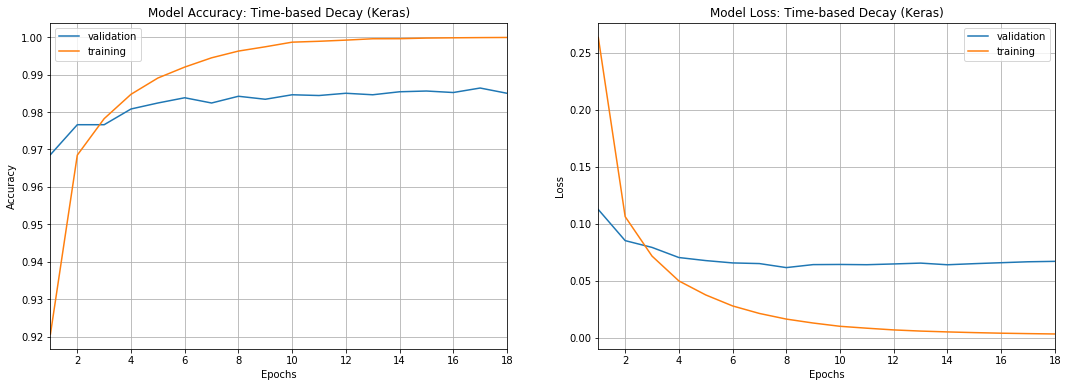

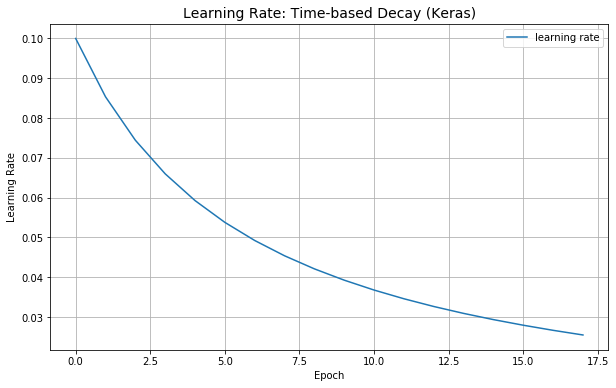

In [38]:
numOfEpochs_time_based_decay_keras = len(history_time_based_decay_keras.history['loss'])
print("Epochs: ", numOfEpochs_time_based_decay_keras)

train_loss_time_based_decay_keras = model_time_based_decay_keras.evaluate(X_train, y_train, verbose=0)[0]
train_accuracy_time_based_decay_keras = model_time_based_decay_keras.evaluate(X_train, y_train, verbose=0)[1]

test_loss_time_based_decay_keras = model_time_based_decay_keras.evaluate(X_test, y_test, verbose=0)[0]
test_accuracy_time_based_decay_keras = model_time_based_decay_keras.evaluate(X_test, y_test, verbose=0)[1]

print("Time-based Decay - Train Accuracy: ", train_accuracy_time_based_decay_keras)
print("Time-based Decay - Test Accuracy: ", test_accuracy_time_based_decay_keras)

print("\nTime-based Decay - Train Loss: ", train_loss_time_based_decay_keras)
print("Time-based Decay - Test Loss: ", test_loss_time_based_decay_keras)


plot_learning_curves(history_time_based_decay_keras, numOfEpochs_time_based_decay_keras, "Time-based Decay (Keras)")


# plot_learning_rate(loss_history_time_based_decay_keras_cb, numOfEpochs_time_based_decay_keras, 
#                    "Learning Rate: Time-based Decay (Keras)")



learning_rate = 0.1
decay = 1e-4
batch_size = 32
no_iterations_per_epoch = len(X_train) // batch_size
epochs = np.arange(numOfEpochs_time_based_decay_keras)
lrs = learning_rate / (1 + decay * epochs * no_iterations_per_epoch)



plt.figure(figsize=(10,6))
plt.plot(epochs, lrs, label='learning rate')
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate: Time-based Decay (Keras)", fontsize=14)
plt.legend(loc=0)
plt.grid(True)
plt.show()

## Experiment 2 (g): Performance-based Learning Schedule by Keras' ReduceLROnPlateau callback class


In performance-based learning schedule we measure the validation error every $s$ steps, and reduce the learning rate by a factor of $\lambda$ when the error stops dropping (i.e., reaches a plateau).

Performance-based learning is implemented in Keras' **ReduceLROnPlateau** callback class. Using this callback we can adjust the learning rate when a plateau in model performance is detected (i.e., no change for a given number of training epochs). This callback is designed to reduce the learning rate after the model stops improving with the hope of fine-tuning model weights.

https://keras.io/api/callbacks/reduce_lr_on_plateau/

The ReduceLROnPlateau requires us to specify the following parameters.

- monitor: It is the metric to monitor. 
- factor: factor by which the learning rate will be reduced: new_lr = lr * factor.
- patience: It specifies the number of training epochs to wait before triggering the change in learning rate.
- mode: one of {'auto', 'min', 'max'}. 
        
        In 'min' mode, the learning rate will be reduced when the quantity monitored has stopped decreasing.

        In 'max' mode it will be reduced when the quantity monitored has stopped increasing.

        In 'auto' mode, the direction is automatically inferred from the name of the monitored quantity.


- min_delta: threshold for measuring the new optimum, to only focus on significant changes.

- cooldown: number of epochs to wait before resuming normal operation after lr has been reduced.

- min_lr: lower bound on the learning rate.


For example, we can monitor the validation loss and reduce the learning rate by an order of magnitude if validation loss does not improve for 10 epochs.

In [39]:
K = keras.backend

class LossHistory_ReduceLROnPlateau(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(K.get_value(self.model.optimizer.lr))

### Experiment 2 (g): Training using Keras' ReduceLROnPlateau callback based Learning Schedule

In [40]:
%%time

keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

model_ReduceLROnPlateau = keras.models.Sequential([
    keras.Input(shape=(784,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])


optimizer=keras.optimizers.SGD(learning_rate=1e-1, momentum=0.1)

model_ReduceLROnPlateau.compile(loss="sparse_categorical_crossentropy",
                         optimizer=optimizer,
                         metrics=["accuracy"])


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

loss_history_ReduceLROnPlateau_cb = LossHistory_ReduceLROnPlateau()

lschedule_ReduceLROnPlateau_cb = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=10, min_lr=0.001, mode='auto', verbose=1)


history_ReduceLROnPlateau = model_ReduceLROnPlateau.fit(X_train, y_train, 
                               batch_size=32, # batch size 32 is default
                               epochs=100,
                               verbose=1,
                               validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, loss_history_ReduceLROnPlateau_cb, 
                               lschedule_ReduceLROnPlateau_cb])


Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 4s 76us/sample - loss: 0.2632 - accuracy: 0.9202 - val_loss: 0.1111 - val_accuracy: 0.9692
Epoch 2/100
55000/55000 [==============================] - 4s 66us/sample - loss: 0.1068 - accuracy: 0.9677 - val_loss: 0.0842 - val_accuracy: 0.9774
Epoch 3/100
55000/55000 [==============================] - 4s 67us/sample - loss: 0.0725 - accuracy: 0.9775 - val_loss: 0.0775 - val_accuracy: 0.9770
Epoch 4/100
55000/55000 [==============================] - 4s 70us/sample - loss: 0.0510 - accuracy: 0.9837 - val_loss: 0.0729 - val_accuracy: 0.9786
Epoch 5/100
55000/55000 [==============================] - 4s 70us/sample - loss: 0.0375 - accuracy: 0.9887 - val_loss: 0.0680 - val_accuracy: 0.9808
Epoch 6/100
55000/55000 [==============================] - 4s 67us/sample - loss: 0.0281 - accuracy: 0.9914 - val_loss: 0.0744 - val_accuracy: 0.9814
Epoch 7/100
55000/55000 [==========================

### Experiment 2 (g): Evaluation using Keras' ReduceLROnPlateau callback based Learning Schedule

Epochs:  19
Time-based Decay - Train Accuracy:  0.9992727
Time-based Decay - Test Accuracy:  0.9832

Time-based Decay - Train Loss:  0.005108292749064805
Time-based Decay - Test Loss:  0.06106927128024836


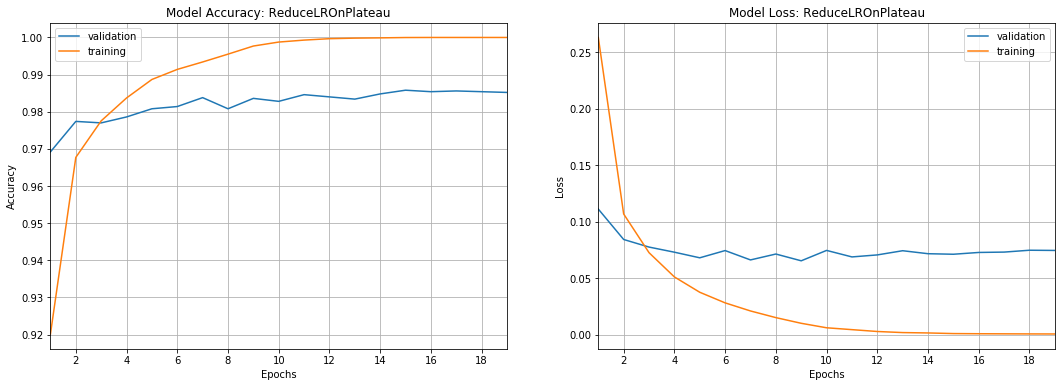

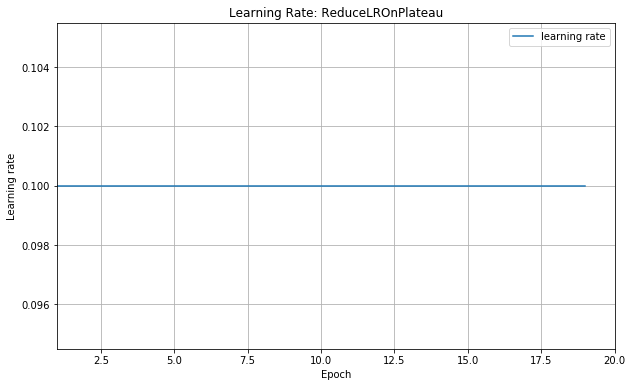

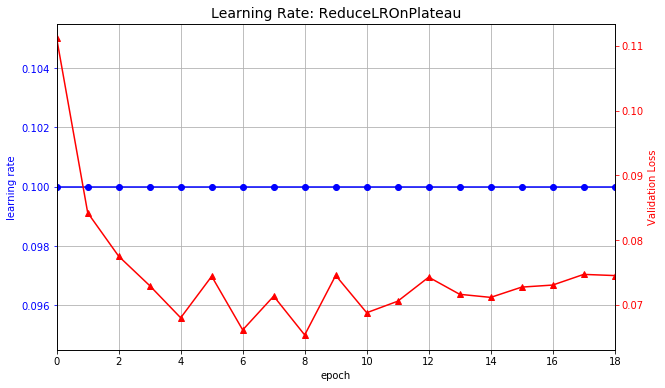

In [41]:
numOfEpochs_ReduceLROnPlateau = len(history_ReduceLROnPlateau.history['loss'])
print("Epochs: ", numOfEpochs_ReduceLROnPlateau )

train_loss_ReduceLROnPlateau = model_ReduceLROnPlateau.evaluate(X_train, y_train, verbose=0)[0]
train_accuracy_ReduceLROnPlateau = model_ReduceLROnPlateau.evaluate(X_train, y_train, verbose=0)[1]

test_loss_ReduceLROnPlateau = model_ReduceLROnPlateau.evaluate(X_test, y_test, verbose=0)[0]
test_accuracy_ReduceLROnPlateau = model_ReduceLROnPlateau.evaluate(X_test, y_test, verbose=0)[1]

print("Time-based Decay - Train Accuracy: ", train_accuracy_ReduceLROnPlateau)
print("Time-based Decay - Test Accuracy: ", test_accuracy_ReduceLROnPlateau)

print("\nTime-based Decay - Train Loss: ", train_loss_ReduceLROnPlateau)
print("Time-based Decay - Test Loss: ", test_loss_ReduceLROnPlateau)


plot_learning_curves(history_ReduceLROnPlateau, numOfEpochs_ReduceLROnPlateau , "ReduceLROnPlateau")

plot_learning_rate(loss_history_ReduceLROnPlateau_cb, numOfEpochs_ReduceLROnPlateau , 
                   "Learning Rate: ReduceLROnPlateau")


plt.figure(figsize=(10,6))
plt.plot(history_ReduceLROnPlateau.epoch, history_ReduceLROnPlateau.history["lr"], "bo-")
plt.xlabel("epoch")
plt.ylabel("learning rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, numOfEpochs_ReduceLROnPlateau - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history_ReduceLROnPlateau.epoch, history_ReduceLROnPlateau.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Learning Rate: ReduceLROnPlateau", fontsize=14)
plt.show()

## Experiment 2 (h): Cyclical Learning Rate (CLR) Schedule


All learning schedules that we have discussed so far share a common characteristic: 

- They **monotonically decrease learning rate (LR)**.


In these schedules, the initial LR is larger, then it is reduced monotonically (after each epoch). We never increased the LR during the training. We believed that increasing LR would have detrimental effect on convergence as it might overshoot the gradients. Thus, we never advocated increasing LR.


However, there are a few problems with a monotonically decreasing learning rate:

- Our model and optimizer are sensitive to our initial choice in LR. We would not know whether the initial LR was too small.

- Finding the initial LR is expensive, requiring time-consuming gridsearch.

- More fundamentally, decreasing LR does not guarantee to descend to lower cost space.

To circumvent these issues caused monotonically decresing LR, in 2017 Leslie Smith proposed a very different kind of lerning schedule in which the **LR is varied during training**. It is known as the Cyclical Learning Rate (CLR):

https://arxiv.org/pdf/1506.01186.pdf

Smith argues that the negative effect of increasing LR is short-term and it will encur long-term benefit. CLR is based on this insight. In CLR we vary the LR within a bound. We choose a minimum bound (base_lr) and a maximum bound (max_lr); and determine a step-size (number of iterations) during which LR increases from base_lr to max_lr. Then, using the same step-size it decreases from max_lr to base_lr. This cycle of increase-decrease-increase repeats with a constant frequency (fixed step-size) throughout the training. Thus the name Cyclical LR. 


An illustration of CLR is shown below. Observe that the LR follows a triangular pattern. First, it is very small (base_lr). Then, it continues to grow until it hits the maximum value (max_lr). The LR then descends back down to the base value (base_lr). This cyclical pattern continues throughout training.


<img src="http://engineering.unl.edu/images/uploads/CyclicalLearningRate-All.png" width=600 height=400>



#### Variations of CLR

Other than the Triangular CLR, two variations are suggested by Smith.

- Triangular2

        The max_lr is halved after every cycle.


- Exponential Range

        The max_lr is reduced exponentially with each iteration.



#### Why is CLR better than monotonically decreasing LR?

We give two reasons.

##### Reason 1:

Learning in ANNs is stalled due to two main topological factors of the ANN cost space.
- Shallow ANNs: SGD gets stuck at bad local minima.
- Deep ANNs: SGD gets stuck at saddle points.


Smaller learning rate may not be sufficient to escape from these two types of topologies of the cost space. CLR increases the likehood of jumping out of these spaces by cyclically increasing the LR.

##### Reason 2:
How do we know that our initial choice of LR is not too small? If we set it smaller than necessary then convergence would be extremely slow from the beginning. Our model is sensitive to the choice of the initial LR. CLR enables us to quickly move from smaller LR. Obviously we have to choose the base_lr and max_lr, as well as the step-size carefully.

In practice, using CLRs leads to far fewer learning rate tuning experiments along with near identical accuracy to exhaustive hyperparameter tuning.


#### Implementing CLR


To implement CLR, we need to determine the following three parameters:
- Step-size
- Base LR
- Maximum LR


The step-size (as well as the length of a cycle which is twice of step-size) can be easily computed from the number of iterations in an epoch. An epoch is calculated by dividing the number of training instances by the size of the mini-batch used.

Smith empirically determined that it is often good to set step-size equal to $2 \sim 10$ times the number of iterations in an epoch. However, he also mentioned that the accuracy of the model is quite robust to cycle length.

The base LR and maximum LR are determined by performing the **LR range test**. We describe it later.

The code for **CyclicLR** class is re-used from the following link.
https://github.com/bckenstler/CLR/blob/master/clr_callback.py

In [42]:
class CyclicLR(keras.callbacks.Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
        
        
        
        
K = keras.backend
        
# A class to store the changing loss and learning rates at each epoch.
class LossHistory_CLR(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(K.get_value(self.model.optimizer.lr))

### LR Range Test: Determining Base LR and Maximum LR

To estimate the reasonable base_lr and max_lr values, we train the model for several epochs while letting the learning rate increase linearly between low and high LR values. We may choose a very small LR as the base_lr and a very high LR as the max_lr. Then, we increase the LR linearly from the minimum value to the maximum value during this short training period. Finaly, we plot the training accuracy versus LR to determine base_lr and max_lr as follows: 

- base_lr: should be set as the LR at which the accuracy starts to increase. 

- max_lr: should be set as the LR at which the accuracy accuracy slows, becomes ragged or starts to fall. 


Smith suggests several ways to choose the minimum learning rate bound: 
1. A factor of 3 or 4 less than the maximum bound.
2. By a short test of hundreds of iterations with a few initial learning rates and pick the largest one that allows convergence to begin without signs of overfitting.

In [47]:
%%time

keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

model_clr = keras.models.Sequential([
    keras.Input(shape=(784,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])


optimizer=keras.optimizers.SGD(learning_rate=1e-1, momentum=0.1)


model_clr.compile(loss="sparse_categorical_crossentropy",
                         optimizer=optimizer,
                         metrics=["accuracy"])



loss_history_clr_cb = LossHistory_CLR()

lschedule_clr_cb = CyclicLR(base_lr=0.001, max_lr=0.9, step_size=13750., mode='triangular')

history_clr  = model_clr.fit(X_train, y_train, 
                               batch_size=32, # batch size 32 is default
                               epochs=8,
                               verbose=1,
                               validation_data=(X_valid, y_valid),
                             callbacks=[loss_history_clr_cb, lschedule_clr_cb])


Train on 55000 samples, validate on 5000 samples
Epoch 1/8
55000/55000 [==============================] - 5s 86us/sample - loss: 0.5574 - accuracy: 0.8389 - val_loss: 0.1579 - val_accuracy: 0.9508
Epoch 2/8
55000/55000 [==============================] - 4s 82us/sample - loss: 0.1546 - accuracy: 0.9530 - val_loss: 0.1035 - val_accuracy: 0.9684
Epoch 3/8
55000/55000 [==============================] - 5s 83us/sample - loss: 0.1148 - accuracy: 0.9650 - val_loss: 0.1028 - val_accuracy: 0.9692
Epoch 4/8
55000/55000 [==============================] - 4s 77us/sample - loss: 0.1065 - accuracy: 0.9664 - val_loss: 0.1458 - val_accuracy: 0.9610
Epoch 5/8
55000/55000 [==============================] - 4s 77us/sample - loss: 0.1032 - accuracy: 0.9691 - val_loss: 0.1553 - val_accuracy: 0.9582
Epoch 6/8
55000/55000 [==============================] - 4s 78us/sample - loss: 0.1156 - accuracy: 0.9672 - val_loss: 0.2409 - val_accuracy: 0.9386
Epoch 7/8
55000/55000 [==============================] - 4s 78u

### LR Range Test: Learning Rate vs Accuracy Plot

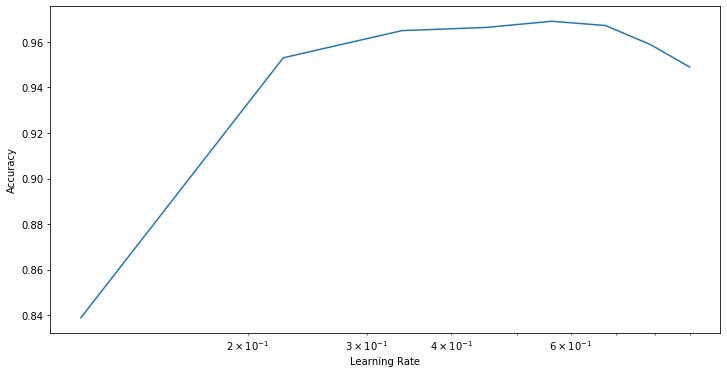

In [48]:
plt.figure(figsize = (12,6))
plt.plot(loss_history_clr_cb.lr, history_clr.history['accuracy'])
plt.gca().set_xscale('log')
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.show()

### LR Range Test: Set base_lr and max_lr

Based on the LR vs accuracy plot, we choose the base and maximum LR as follows:

- base_lr = 0.01
- max_lr = 0.3

### Experiment 2 (h): Training using CLR  Schedule

In [49]:
%%time

keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

model_clr = keras.models.Sequential([
    keras.Input(shape=(784,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])


optimizer=keras.optimizers.SGD(learning_rate=1e-1, momentum=0.1)


model_clr .compile(loss="sparse_categorical_crossentropy",
                         optimizer=optimizer,
                         metrics=["accuracy"])


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

loss_history_clr_cb = LossHistory_CLR()


'''
step_size = 8 * no_of_iterations_epoch

no_of_iterations_epoch = size_of_training_data/size_of_mini_batch

'''
lschedule_clr_cb = CyclicLR(base_lr=0.01, max_lr=0.3, step_size=13750., mode='triangular')

history_clr  = model_clr.fit(X_train, y_train, 
                               batch_size=32, # batch size 32 is default
                               epochs=100,
                               verbose=1,
                               validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, loss_history_clr_cb, lschedule_clr_cb])


Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 5s 87us/sample - loss: 0.5140 - accuracy: 0.8622 - val_loss: 0.2155 - val_accuracy: 0.9354
Epoch 2/100
55000/55000 [==============================] - 5s 83us/sample - loss: 0.1851 - accuracy: 0.9450 - val_loss: 0.1177 - val_accuracy: 0.9674
Epoch 3/100
55000/55000 [==============================] - 4s 77us/sample - loss: 0.1182 - accuracy: 0.9648 - val_loss: 0.1022 - val_accuracy: 0.9688
Epoch 4/100
55000/55000 [==============================] - 4s 77us/sample - loss: 0.0890 - accuracy: 0.9721 - val_loss: 0.0948 - val_accuracy: 0.9712
Epoch 5/100
55000/55000 [==============================] - 4s 77us/sample - loss: 0.0736 - accuracy: 0.9768 - val_loss: 0.0921 - val_accuracy: 0.9736
Epoch 6/100
55000/55000 [==============================] - 4s 80us/sample - loss: 0.0640 - accuracy: 0.9794 - val_loss: 0.1103 - val_accuracy: 0.9668
Epoch 7/100
55000/55000 [==========================

### Experiment 2 (h): Evaluation using CLR Schedule

Epochs:  22
CLR - Train Accuracy:  0.9995818
CLR - Test Accuracy:  0.9842

CLR - Train Loss:  0.0022990717683236818
CLR - Test Loss:  0.06611994177724087


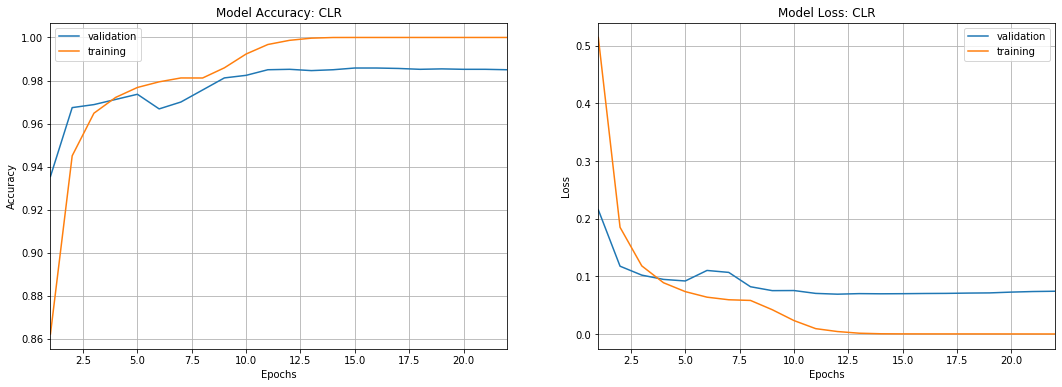

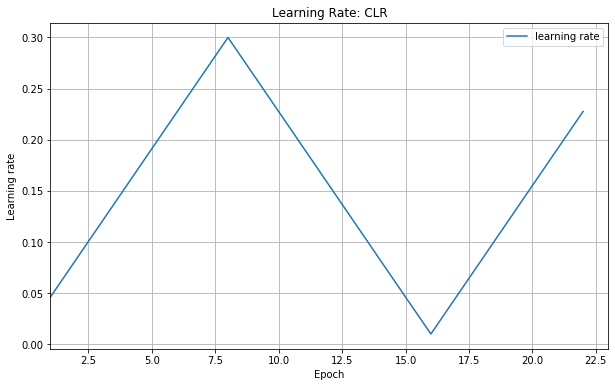

In [50]:
numOfEpochs_clr  = len(history_clr.history['loss'])
print("Epochs: ", numOfEpochs_clr)

train_loss_clr = model_clr.evaluate(X_train, y_train, verbose=0)[0]
train_accuracy_clr = model_clr.evaluate(X_train, y_train, verbose=0)[1]

test_loss_clr = model_clr.evaluate(X_test, y_test, verbose=0)[0]
test_accuracy_clr = model_clr.evaluate(X_test, y_test, verbose=0)[1]

print("CLR - Train Accuracy: ", train_accuracy_clr)
print("CLR - Test Accuracy: ", test_accuracy_clr)

print("\nCLR - Train Loss: ", train_loss_clr)
print("CLR - Test Loss: ", test_loss_clr)


plot_learning_curves(history_clr, numOfEpochs_clr, "CLR")

plot_learning_rate(loss_history_clr_cb, numOfEpochs_clr, 
                   "Learning Rate: CLR")

## Experiment 2 (i): One Cycle Learning Schedule




Can we train an ANN an order of magnitude faster than with standard training methods? In other words, can we devise a technique that make convergence super fast?

Well, faster convergence requires us to use very large LRs. Smith and Topin in their 2017 paper obsered that during the LR range test (on CIFAR-10 and CIFAR-100 datasets) for the CLR policy the test loss and accuracy remain nearly constant, even up to very large LRs. Based on this observation, they suggested it is indeed possible to achieve **super-convergence**.

https://arxiv.org/pdf/1708.07120.pdf

To achieve super-convergence, they tweaked the CLR policy slightly and suggested to use only one learning rate cycle; and a large maximum learning rate. This novel LR policy is named as **1cycle** policy. We use just one cycle that is smaller than the total number of iterations/epochs and allow the learning rate to decrease several orders of magnitude less than the initial learning rate for the remaining iterations. With 1cycle policy we can use an unusually large learning rate. The very large learning rates offer two benefits: regularization and faster convergence. It was shown empirically that 1cycle policy allows the accuracy to plateau before the training ends.

https://arxiv.org/pdf/1803.09820.pdf



#### 1cycle Policy

The 1cycle starts by increasing the initial learning rate (init_lr), growing linearly up to max_lr halfway through training. Then it decreases the learning rate linearly down to init_lr again during the second half of training, finishing the last few epochs by dropping the rate down by several orders of magnitude in a linear fashion. The max_lr is chosen using the same approach we used to find the optimal learning rate, and the init_lr is chosen to be roughly 10 times lower. 


#### 1cycle Policy with Momentum

Momentum and LR are closely related. The optimal learning rate is dependent on the momentum, and vice versa. Like LRs, it is valuable to set momentum as large as possible without causing instabilities during training. Thus, it is beneficial to adopt a **cyclical momentum policy** as well.

Smith showed that using a **decreasing** cyclical momentum when the learning rate increases provides an equivalent result to the best constant momentum value but stabilizes the training to allow larger learning rates. More specifically, it provides three benefits: (1) a lower minimum test loss, (2) faster initial convergence, and (3) greater convergence stability over a larger range of learning rates. 

However, unlike the LR range test, a momentum range test is not useful for finding an optimal momentum. It is very important to choose the optimal momentum wisely.

Smith found the following empirical policy quite effective.

- Start with a high momentum first (e.g., 0.95), then drop it down to a lower momentum during the first half of training (e.g., down to 0.85, linearly), and then bring it back up to the maximum value (e.g., 0.95) during the second half of training, finishing the last few epochs with that maximum value. 

Smith did many experiments showing that this approach was often able to speed up training considerably and reach better performance. For example, on the popular CIFAR-10 image dataset, this approach reached 91.9% validation accuracy in just 100 epochs, instead of 90.3% accuracy in 800 epochs through a standard approach (with the same neural network architecture).


##### Following OneCycle callback class  implements the 1cycle policy for both the LR and momentum.

- For the MNIST dataset we don't observe any benefit of varying momentum, thus it is kept constant throughout the training.

In [51]:
class OneCycle(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, momentum_vals=(0.95, 0.85), start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
        
        self.step_len =  int(self.iterations * (1 - 10.0/100.0)/2)
        
        self.low_mom = momentum_vals[1]
        self.high_mom = momentum_vals[0]
        
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    
    def on_batch_begin(self, batch, logs):
        
        # Set Learning Rate
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)
        
        
        # Set Momentum
        if self.iteration == 0:
            return self.high_mom
        elif self.iteration == self.iterations:
            self.iteration = 0
            return self.high_mom
        elif self.iteration > 2 * self.step_len:
            mom = self.high_mom
        elif self.iteration > self.step_len:
            ratio = (self.iteration - self.step_len)/self.step_len
            mom = self.low_mom + ratio * (self.high_mom - self.low_mom)
        else :
            ratio = self.iteration/self.step_len
            mom = self.high_mom - ratio * (self.high_mom - self.low_mom)
        K.set_value(self.model.optimizer.momentum, mom)

        
        
        
        
K = keras.backend
        
# A class to store the changing loss and learning rates at each epoch.
class LossHistory_OneCycle(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        self.mom = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(K.get_value(self.model.optimizer.lr))
        self.mom.append(K.get_value(self.model.optimizer.momentum))

## Finding the Maximum Learning Rate for 1cycle Schedule

First, we build the DNN.

Then, we create an IncreaseLearningRate object (class defined above). At each iteration it increases the learning rate by a factor determined by the computeFactorForIncreasingLearningRate function. We pass this object as a callback to the fit() method of the model.

At the completion of training (for a few epochs), we use the loss vs. learning rate plot to find the maximum learning rate for 1cycle schedule.

In [64]:
keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.Input(shape=(784,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])


optimizer=keras.optimizers.SGD(learning_rate=1e-1, momentum=0.1)


model.compile(loss="sparse_categorical_crossentropy",
                         optimizer=optimizer,
                         metrics=["accuracy"])

'''
Create an IncreaseLearningRate object.
It increases the learning rate by 0.5% at each iteration:
We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration.
'''
size_mini_batch = 32
no_of_epochs = 1
upper_bound_lr = 5
lower_bound_lr = 1e-5
increase_factor = computeFactorForIncreasingLearningRate(X_train, size_mini_batch, no_of_epochs, 
                                                         upper_bound_lr, lower_bound_lr)
increase_lr_cb = IncreaseLearningRate(factor=increase_factor)

'''
Train the model
'''
model.fit(X_train, y_train, 
                    batch_size=size_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[increase_lr_cb])

Train on 55000 samples, validate on 5000 samples
55000/55000 [==============================] - 5s 91us/sample - loss: nan - accuracy: 0.2146 - val_loss: nan - val_accuracy: 0.0958


## Plot the Loss as a Function of the Learning Rate

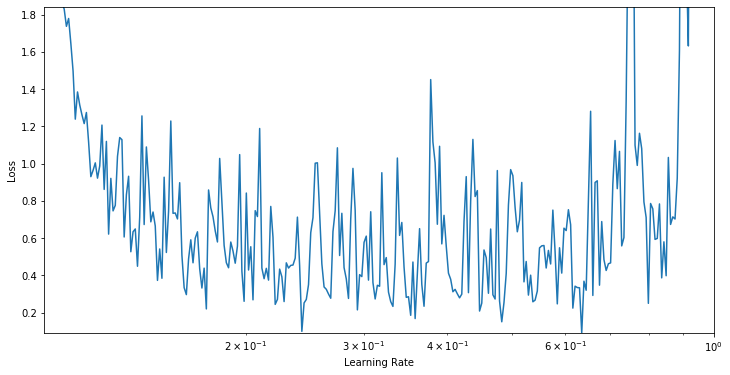

In [66]:
plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(min(increase_lr_cb.rates), 1)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()


## Maximum Learning Rate for 1cycle Schedule
We see that the loss starts increasing with large oscillation right after the learning rate 0.4. Thus, we use 0.4 as our maximum learning rate.

It is used to create the OneCycle object (set the value of the argument "max_rate").

### Experiment 2 (i): Training using One Cycle Schedule

In [71]:
%%time

keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

model_oneCycle = keras.models.Sequential([
    keras.Input(shape=(784,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])


optimizer=keras.optimizers.SGD(learning_rate=1e-1, momentum=0.1)
#optimizer=keras.optimizers.SGD()


model_oneCycle.compile(loss="sparse_categorical_crossentropy",
                         optimizer=optimizer,
                         metrics=["accuracy"])


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

loss_history_oneCycle_cb = LossHistory_OneCycle()



'''
The OneCycle object takes 3 arguments:
- Total number of iterations during the full training
- Maximum learning rate
- Initial learning rate

Total number of iterations = (size_of_training_data/size_of_mini_batch) * no_of_epochs

'''

no_of_epochs = 25
size_of_mini_batch = 32
no_iterations = (len(X_train) // size_of_mini_batch) * no_of_epochs


lschedule_oneCycle_cb = OneCycle(no_iterations, max_rate=0.4, momentum_vals=(0.1, 0.1))


history_oneCycle  = model_oneCycle.fit(X_train, y_train, 
                               batch_size=size_of_mini_batch, 
                               epochs=no_of_epochs,
                               verbose=1,
                               validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, loss_history_oneCycle_cb, lschedule_oneCycle_cb])


Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 5s 89us/sample - loss: 0.3436 - accuracy: 0.9010 - val_loss: 0.1507 - val_accuracy: 0.9554
Epoch 2/25
55000/55000 [==============================] - 4s 79us/sample - loss: 0.1412 - accuracy: 0.9582 - val_loss: 0.1001 - val_accuracy: 0.9720
Epoch 3/25
55000/55000 [==============================] - 4s 79us/sample - loss: 0.0971 - accuracy: 0.9707 - val_loss: 0.0912 - val_accuracy: 0.9712
Epoch 4/25
55000/55000 [==============================] - 4s 81us/sample - loss: 0.0761 - accuracy: 0.9758 - val_loss: 0.0951 - val_accuracy: 0.9716
Epoch 5/25
55000/55000 [==============================] - 5s 82us/sample - loss: 0.0648 - accuracy: 0.9794 - val_loss: 0.1044 - val_accuracy: 0.9680
Epoch 6/25
55000/55000 [==============================] - 4s 78us/sample - loss: 0.0563 - accuracy: 0.9820 - val_loss: 0.1208 - val_accuracy: 0.9660
Epoch 7/25
55000/55000 [==============================] -

### Experiment 2 (i): Evaluation using One Cycle Learning Schedule

Epochs:  25
One Cycle - Train Accuracy:  1.0
One Cycle - Test Accuracy:  0.9855

One Cycle - Train Loss:  8.872467433172346e-05
One Cycle - Test Loss:  0.08559031231070154


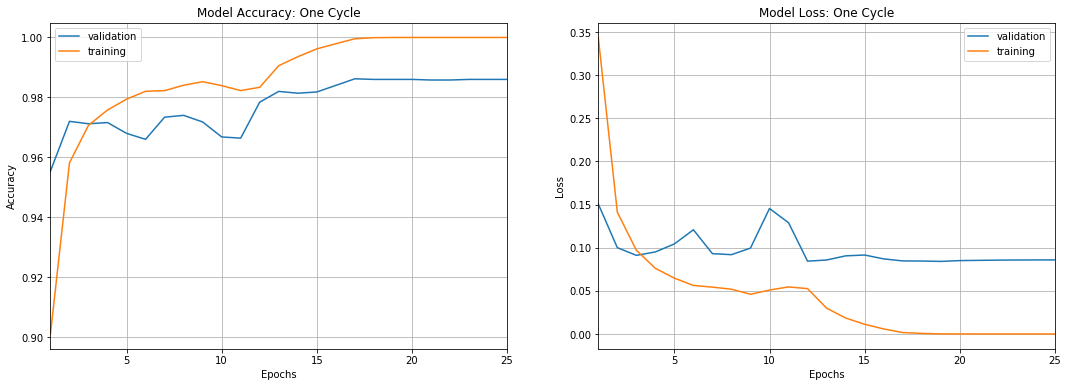

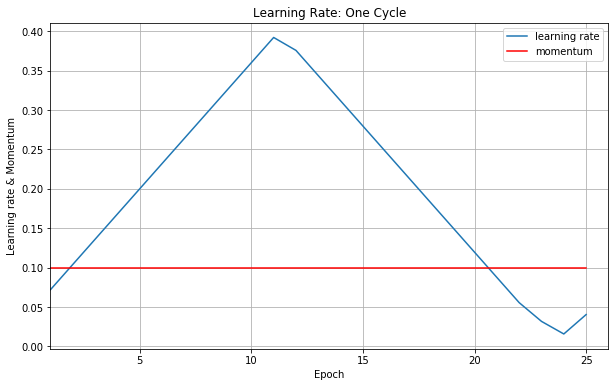

In [72]:
numOfEpochs_oneCycle  = len(history_oneCycle.history['loss'])
print("Epochs: ", numOfEpochs_oneCycle)

train_loss_oneCycle = model_oneCycle.evaluate(X_train, y_train, verbose=0)[0]
train_accuracy_oneCycle = model_oneCycle.evaluate(X_train, y_train, verbose=0)[1]

test_loss_oneCycle = model_oneCycle.evaluate(X_test, y_test, verbose=0)[0]
test_accuracy_oneCycle = model_oneCycle.evaluate(X_test, y_test, verbose=0)[1]

print("One Cycle - Train Accuracy: ", train_accuracy_oneCycle)
print("One Cycle - Test Accuracy: ", test_accuracy_oneCycle)

print("\nOne Cycle - Train Loss: ", train_loss_oneCycle)
print("One Cycle - Test Loss: ", test_loss_oneCycle)


plot_learning_curves(history_oneCycle, numOfEpochs_oneCycle, "One Cycle")

plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_oneCycle, 
                   "Learning Rate: One Cycle", momentumPlot=True)


# Experiment 3: Adaptive Learning Rates using Extensions of SGD


There are two limitations of using learning schedules with SGD.

- The biggest limitation is that we need to define the hyperparameters in advance. The optimal settings depend on the model architecture and the data.

- The same learning rate is applied to all parameter updates. If we have sparse data, we may want to update the parameters in different extent instead.

These limitations are addressed by **Adaptive gradient descent algorithms**. 

These algorithms provide per-parameter learning rate. These are based on heuristic approach without requiring expensive work in tuning hyperparameters for the learning rate schedule manually.

We explore the following adaptive learning rate algorithms:
- Adagrad
- Adadelta
- RMSprop
- Adam
- Nadam


To understand the motivation behind adaptive learning rate algorithms, see the discussion in this notebook:
https://github.com/rhasanbd/Multi-Layer-Perceptron-Curious-Dabbling/blob/master/MLP-II-Nonlinear%20Data%20%26%20Multi-Layer%20Perceptron.ipynb


A quick comparatiove discussion of these algorithms reveal that **Adagrad** performs larger updates for more sparse parameters and smaller updates for less sparse parameter. It has good performance with sparse data and training large-scale neural networks. However, its monotonic learning rate usually proves too aggressive and stops learning too early when training deep neural networks. **Adadelta** is an extension of Adagrad that seeks to reduce its aggressive, monotonically decreasing learning rate. **RMSprop** adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate. **Adam** is an update to the RMSProp optimizer which is like RMSprop with momentum. **Nadam**  accelerates the speed of Adam with Nesterov momentum.

Keras provides functions for these adaptive learning algorithms that we can use with corresponding optimizers. It is usually recommended to leave the hyperparameters of these optimizers at their default values. 

- The only hyperparameter that we might need to adjust is the learning rate.

Another hyperparameter is epsilon which should be a small constant for numerical stability. 

## Experiment 3: Adaptive Learning Rate by Adagrad Optimizer

Adagrad is an optimizer with parameter-specific learning rates, which are adapted relative to how frequently a parameter gets updated during training. 

The more updates a parameter receives, the smaller the updates.

In [73]:
K = keras.backend

class LossHistory_Adagrad(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(K.get_value(self.model.optimizer.lr))

### Experiment 3: Training using Adagrad Optimizer

In [74]:
%%time

keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

model_Adagrad = keras.models.Sequential([
    keras.Input(shape=(784,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])



optimizer=keras.optimizers.Adagrad(lr=0.05, epsilon=1e-07, decay=0.0)

model_Adagrad.compile(loss="sparse_categorical_crossentropy",
                         optimizer=optimizer,
                         metrics=["accuracy"])


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

loss_history_Adagrad_cb = LossHistory_Adagrad()


history_Adagrad = model_Adagrad.fit(X_train, y_train, 
                               batch_size=32, # batch size 32 is default
                               epochs=100,
                               verbose=1,
                               validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, loss_history_Adagrad_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 5s 95us/sample - loss: 0.2422 - accuracy: 0.9266 - val_loss: 0.1021 - val_accuracy: 0.9716
Epoch 2/100
55000/55000 [==============================] - 4s 79us/sample - loss: 0.0973 - accuracy: 0.9709 - val_loss: 0.0822 - val_accuracy: 0.9772
Epoch 3/100
55000/55000 [==============================] - 4s 79us/sample - loss: 0.0646 - accuracy: 0.9799 - val_loss: 0.0701 - val_accuracy: 0.9780
Epoch 4/100
55000/55000 [==============================] - 5s 84us/sample - loss: 0.0442 - accuracy: 0.9862 - val_loss: 0.0666 - val_accuracy: 0.9794
Epoch 5/100
55000/55000 [==============================] - 5s 83us/sample - loss: 0.0325 - accuracy: 0.9902 - val_loss: 0.0653 - val_accuracy: 0.9814
Epoch 6/100
55000/55000 [==============================] - 4s 81us/sample - loss: 0.0229 - accuracy: 0.9936 - val_loss: 0.0686 - val_accuracy: 0.9822
Epoch 7/100
55000/55000 [==========================

### Experiment 3: Evaluation using Adagrad Optimizer

Epochs:  18
Time-based Decay - Train Accuracy:  0.9985273
Time-based Decay - Test Accuracy:  0.9824

Time-based Decay - Train Loss:  0.00850829096620225
Time-based Decay - Test Loss:  0.06213632559640391


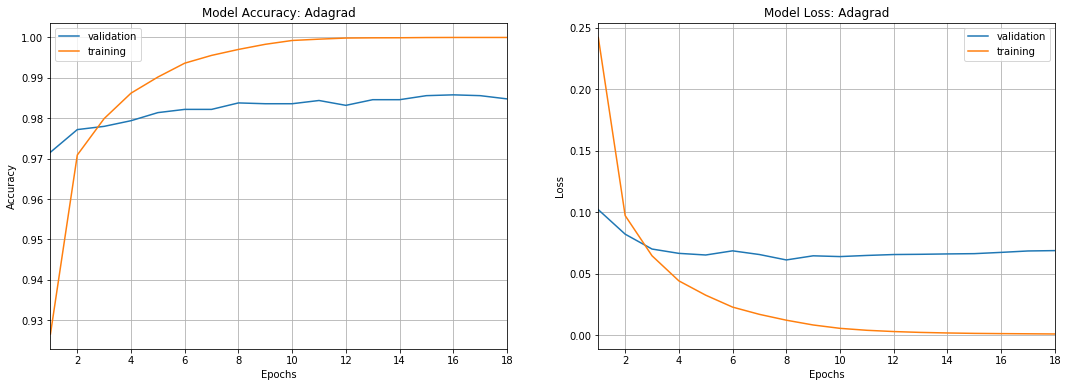

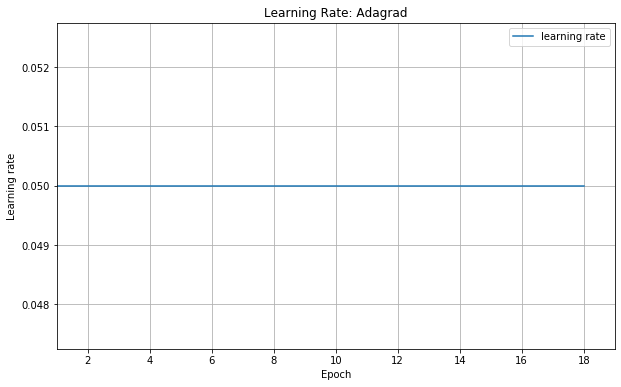

In [75]:
numOfEpochs_Adagrad = len(history_Adagrad.history['loss'])
print("Epochs: ", numOfEpochs_Adagrad )

train_loss_Adagrad = model_Adagrad.evaluate(X_train, y_train, verbose=0)[0]
train_accuracy_Adagrad = model_Adagrad.evaluate(X_train, y_train, verbose=0)[1]

test_loss_Adagrad = model_Adagrad.evaluate(X_test, y_test, verbose=0)[0]
test_accuracy_Adagrad = model_Adagrad.evaluate(X_test, y_test, verbose=0)[1]

print("Time-based Decay - Train Accuracy: ", train_accuracy_Adagrad)
print("Time-based Decay - Test Accuracy: ", test_accuracy_Adagrad)

print("\nTime-based Decay - Train Loss: ", train_loss_Adagrad)
print("Time-based Decay - Test Loss: ", test_loss_Adagrad)


plot_learning_curves(history_Adagrad, numOfEpochs_Adagrad , "Adagrad")

plot_learning_rate(loss_history_Adagrad_cb, numOfEpochs_Adagrad , "Learning Rate: Adagrad")

## Experiment 3: Adaptive Learning Rate by Adadelta Optimizer


Adadelta is a **more robust extension of Adagrad** that adapts learning rates based on a moving window of gradient updates, instead of accumulating all past gradients. This way, Adadelta continues learning even when many updates have been done. 

Adadelta optimization is a stochastic gradient descent method that is based on adaptive learning rate per dimension to address two drawbacks:

- The continual decay of learning rates throughout training
- The need for a manually selected global learning rate


Compared to Adagrad, in the original version of Adadelta we don't have to set an initial learning rate. In this version, initial learning rate can be set, as in most other Keras optimizers.

Three hyperparameters used are: 
- lr: Initial learning rate.
- rho: It's the discounting factor for the history gradient.
- epsilon: A small constant for numerical stability. 

#### Note that the performance of the model is sensitive to the initial learning rate of the Adagrad optimizer.

In [76]:
K = keras.backend

class LossHistory_Adadelta(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(K.get_value(self.model.optimizer.lr))

### Experiment 3: Training using Adadelta Optimizer

In [77]:
%%time

keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

model_Adadelta = keras.models.Sequential([
    keras.Input(shape=(784,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])



optimizer=keras.optimizers.Adadelta(lr=0.1, rho=0.95, epsilon=1e-07, decay=0.0)

model_Adadelta.compile(loss="sparse_categorical_crossentropy",
                         optimizer=optimizer,
                         metrics=["accuracy"])


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

loss_history_Adadelta_cb = LossHistory_Adadelta()


history_Adadelta = model_Adadelta.fit(X_train, y_train, 
                               batch_size=32, # batch size 32 is default
                               epochs=100,
                               verbose=1,
                               validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, loss_history_Adadelta_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 5s 84us/sample - loss: 0.4676 - accuracy: 0.8760 - val_loss: 0.2533 - val_accuracy: 0.9272
Epoch 2/100
55000/55000 [==============================] - 4s 73us/sample - loss: 0.2346 - accuracy: 0.9329 - val_loss: 0.1911 - val_accuracy: 0.9458
Epoch 3/100
55000/55000 [==============================] - 4s 74us/sample - loss: 0.1843 - accuracy: 0.9475 - val_loss: 0.1638 - val_accuracy: 0.9552
Epoch 4/100
55000/55000 [==============================] - 4s 74us/sample - loss: 0.1527 - accuracy: 0.9561 - val_loss: 0.1368 - val_accuracy: 0.9610
Epoch 5/100
55000/55000 [==============================] - 4s 74us/sample - loss: 0.1310 - accuracy: 0.9624 - val_loss: 0.1262 - val_accuracy: 0.9644
Epoch 6/100
55000/55000 [==============================] - 4s 74us/sample - loss: 0.1148 - accuracy: 0.9676 - val_loss: 0.1117 - val_accuracy: 0.9672
Epoch 7/100
55000/55000 [==========================

### Experiment 3: Evaluation using Adadelta Optimizer

Epochs:  44
Time-based Decay - Train Accuracy:  0.99725455
Time-based Decay - Test Accuracy:  0.9807

Time-based Decay - Train Loss:  0.013808173238299788
Time-based Decay - Test Loss:  0.06758231818986242


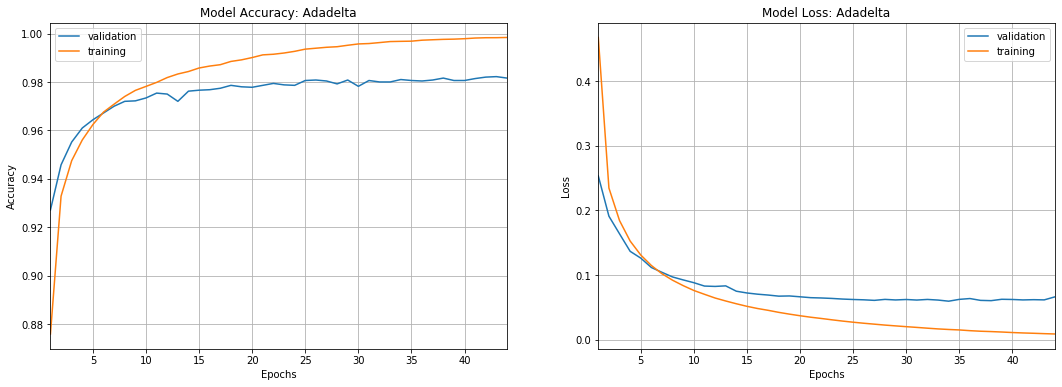

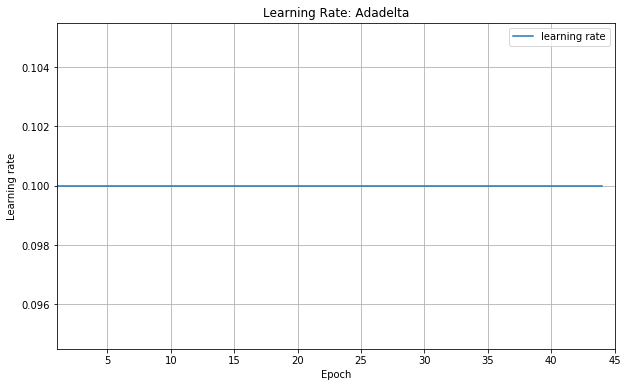

In [78]:
numOfEpochs_Adadelta = len(history_Adadelta.history['loss'])
print("Epochs: ", numOfEpochs_Adadelta )

train_loss_Adadelta = model_Adadelta.evaluate(X_train, y_train, verbose=0)[0]
train_accuracy_Adadelta = model_Adadelta.evaluate(X_train, y_train, verbose=0)[1]

test_loss_Adadelta = model_Adadelta.evaluate(X_test, y_test, verbose=0)[0]
test_accuracy_Adadelta = model_Adadelta.evaluate(X_test, y_test, verbose=0)[1]

print("Time-based Decay - Train Accuracy: ", train_accuracy_Adadelta)
print("Time-based Decay - Test Accuracy: ", test_accuracy_Adadelta)

print("\nTime-based Decay - Train Loss: ", train_loss_Adadelta)
print("Time-based Decay - Test Loss: ", test_loss_Adadelta)


plot_learning_curves(history_Adadelta, numOfEpochs_Adadelta , "Adadelta")

plot_learning_rate(loss_history_Adadelta_cb, numOfEpochs_Adadelta , "Learning Rate: Adadelta")


## Experiment 3: Adaptive Learning Rate by RMSprop Optimizer


The gist of RMSprop is to:

- Maintain a moving (discounted) average of the square of gradients
- Divide the gradient by the root of this average

This implementation of RMSprop uses plain momentum, not Nesterov momentum.


Three hyperparameters used are:

- lr: Initial learning rate.
- rho: It's the discounting factor for the history gradient.
- epsilon: A small constant for numerical stability.


#### Note that the performance of the model is sensitive to the initial learning rate of the RMSprop optimizer. The learning rate should be set to a smaller value.

In [79]:
K = keras.backend

class LossHistory_RMSprop(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(K.get_value(self.model.optimizer.lr))

### Experiment 3: Training using RMSprop Optimizer

In [80]:
%%time

keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

model_RMSprop = keras.models.Sequential([
    keras.Input(shape=(784,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])



optimizer=keras.optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=1e-07, decay=0.0)

model_RMSprop.compile(loss="sparse_categorical_crossentropy",
                         optimizer=optimizer,
                         metrics=["accuracy"])


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

loss_history_RMSprop_cb = LossHistory_RMSprop()


history_RMSprop = model_RMSprop.fit(X_train, y_train, 
                               batch_size=32, # batch size 32 is default
                               epochs=100,
                               verbose=1,
                               validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, loss_history_RMSprop_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 5s 95us/sample - loss: 0.2529 - accuracy: 0.9261 - val_loss: 0.1060 - val_accuracy: 0.9694
Epoch 2/100
55000/55000 [==============================] - 5s 87us/sample - loss: 0.1047 - accuracy: 0.9682 - val_loss: 0.0897 - val_accuracy: 0.9748
Epoch 3/100
55000/55000 [==============================] - 5s 88us/sample - loss: 0.0755 - accuracy: 0.9783 - val_loss: 0.0791 - val_accuracy: 0.9768
Epoch 4/100
55000/55000 [==============================] - 5s 84us/sample - loss: 0.0568 - accuracy: 0.9830 - val_loss: 0.0780 - val_accuracy: 0.9766
Epoch 5/100
55000/55000 [==============================] - 5s 87us/sample - loss: 0.0469 - accuracy: 0.9866 - val_loss: 0.0836 - val_accuracy: 0.9756
Epoch 6/100
55000/55000 [==============================] - 5s 83us/sample - loss: 0.0379 - accuracy: 0.9886 - val_loss: 0.0758 - val_accuracy: 0.9798
Epoch 7/100
55000/55000 [==========================

### Experiment 3: Evaluation using RMSprop Optimizer

Epochs:  16
Time-based Decay - Train Accuracy:  0.99127275
Time-based Decay - Test Accuracy:  0.9788

Time-based Decay - Train Loss:  0.029207672208443877
Time-based Decay - Test Loss:  0.07923325493456505


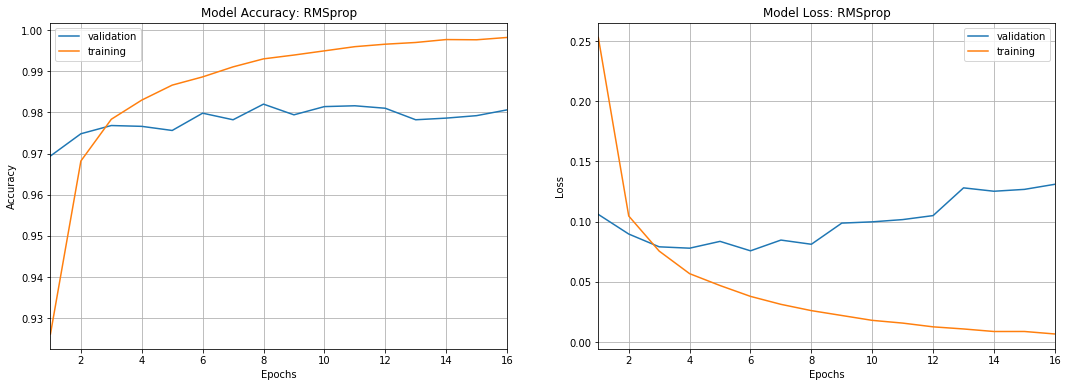

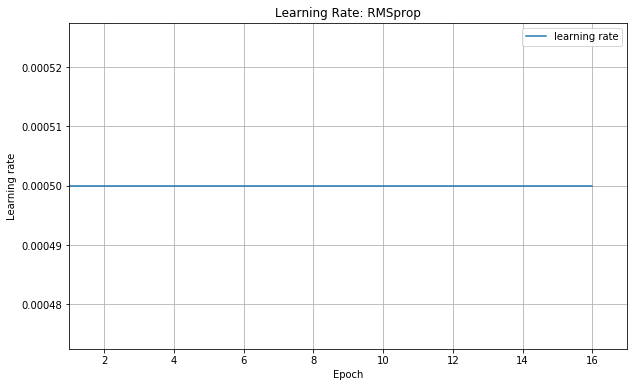

In [81]:
numOfEpochs_RMSprop = len(history_RMSprop.history['loss'])
print("Epochs: ", numOfEpochs_RMSprop )

train_loss_RMSprop = model_RMSprop.evaluate(X_train, y_train, verbose=0)[0]
train_accuracy_RMSprop = model_RMSprop.evaluate(X_train, y_train, verbose=0)[1]

test_loss_RMSprop = model_RMSprop.evaluate(X_test, y_test, verbose=0)[0]
test_accuracy_RMSprop = model_RMSprop.evaluate(X_test, y_test, verbose=0)[1]

print("Time-based Decay - Train Accuracy: ", train_accuracy_RMSprop)
print("Time-based Decay - Test Accuracy: ", test_accuracy_RMSprop)

print("\nTime-based Decay - Train Loss: ", train_loss_RMSprop)
print("Time-based Decay - Test Loss: ", test_loss_RMSprop)


plot_learning_curves(history_RMSprop, numOfEpochs_RMSprop , "RMSprop")

plot_learning_rate(loss_history_RMSprop_cb, numOfEpochs_RMSprop , "Learning Rate: RMSprop")


## Experiment 3: Adaptive Learning Rate by Adam Optimizer


Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.


Four hyperparameters used are:

- lr: Initial learning rate.
- beta_1: The exponential decay rate for the 1st moment estimates.
- beta_2: The exponential decay rate for the 2nd moment estimates.
- epsilon: A small constant for numerical stability.


#### Note that the performance of the model is sensitive to the initial learning rate of the Adam optimizer. The learning rate should be set to a smaller value.

In [82]:
K = keras.backend

class LossHistory_Adam(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(K.get_value(self.model.optimizer.lr))

### Experiment 3: Training using Adam Optimizer

In [83]:
%%time

keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

model_Adam = keras.models.Sequential([
    keras.Input(shape=(784,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])



optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0)

model_Adam.compile(loss="sparse_categorical_crossentropy",
                         optimizer=optimizer,
                         metrics=["accuracy"])


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

loss_history_Adam_cb = LossHistory_Adam()


history_Adam = model_Adam.fit(X_train, y_train, 
                               batch_size=32, # batch size 32 is default
                               epochs=100,
                               verbose=1,
                               validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, loss_history_Adam_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 5s 85us/sample - loss: 0.4783 - accuracy: 0.8757 - val_loss: 0.2304 - val_accuracy: 0.9324
Epoch 2/100
55000/55000 [==============================] - 4s 73us/sample - loss: 0.2062 - accuracy: 0.9418 - val_loss: 0.1641 - val_accuracy: 0.9556
Epoch 3/100
55000/55000 [==============================] - 4s 71us/sample - loss: 0.1520 - accuracy: 0.9563 - val_loss: 0.1369 - val_accuracy: 0.9642
Epoch 4/100
55000/55000 [==============================] - 4s 74us/sample - loss: 0.1197 - accuracy: 0.9655 - val_loss: 0.1104 - val_accuracy: 0.9686
Epoch 5/100
55000/55000 [==============================] - 4s 76us/sample - loss: 0.0985 - accuracy: 0.9716 - val_loss: 0.1032 - val_accuracy: 0.9712
Epoch 6/100
55000/55000 [==============================] - 4s 76us/sample - loss: 0.0828 - accuracy: 0.9768 - val_loss: 0.0867 - val_accuracy: 0.9744
Epoch 7/100
55000/55000 [==========================

### Experiment 3: Evaluation using Adam Optimizer

Epochs:  27
Time-based Decay - Train Accuracy:  0.9981091
Time-based Decay - Test Accuracy:  0.9789

Time-based Decay - Train Loss:  0.012481681516648016
Time-based Decay - Test Loss:  0.07266299106132938


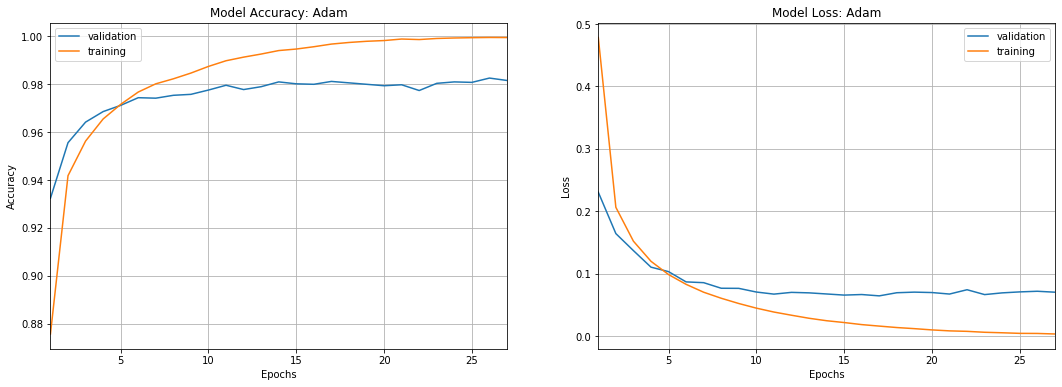

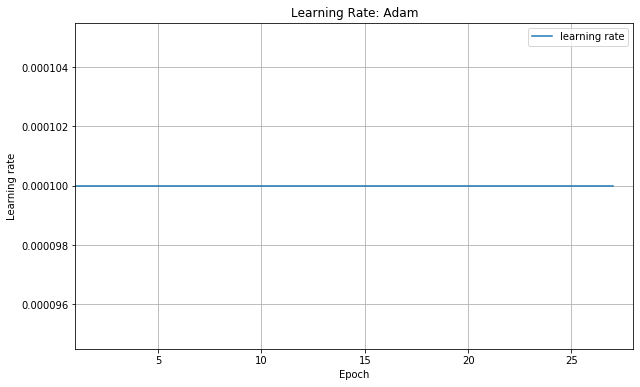

In [84]:
numOfEpochs_Adam = len(history_Adam.history['loss'])
print("Epochs: ", numOfEpochs_Adam )

train_loss_Adam = model_Adam.evaluate(X_train, y_train, verbose=0)[0]
train_accuracy_Adam = model_Adam.evaluate(X_train, y_train, verbose=0)[1]

test_loss_Adam = model_Adam.evaluate(X_test, y_test, verbose=0)[0]
test_accuracy_Adam = model_Adam.evaluate(X_test, y_test, verbose=0)[1]

print("Time-based Decay - Train Accuracy: ", train_accuracy_Adam)
print("Time-based Decay - Test Accuracy: ", test_accuracy_Adam)

print("\nTime-based Decay - Train Loss: ", train_loss_Adam)
print("Time-based Decay - Test Loss: ", test_loss_Adam)


plot_learning_curves(history_Adam, numOfEpochs_Adam , "Adam")

plot_learning_rate(loss_history_Adam_cb, numOfEpochs_Adam , "Learning Rate: Adam")


## Experiment 3: Adaptive Learning Rate by NAdam Optimizer

Nadam is Adam with Nesterov momentum.

In [85]:
K = keras.backend

class LossHistory_Nadam(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(K.get_value(self.model.optimizer.lr))

### Experiment 3: Training using NAdam Optimizer

In [86]:
%%time

keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

model_Nadam = keras.models.Sequential([
    keras.Input(shape=(784,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])


optimizer=keras.optimizers.Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)


model_Nadam.compile(loss="sparse_categorical_crossentropy",
                         optimizer=optimizer,
                         metrics=["accuracy"])


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

loss_history_Nadam_cb = LossHistory_Nadam()


history_Nadam = model_Nadam.fit(X_train, y_train, 
                               batch_size=32, # batch size 32 is default
                               epochs=100,
                               verbose=1,
                               validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, loss_history_Nadam_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 6s 113us/sample - loss: 0.4787 - accuracy: 0.8750 - val_loss: 0.2294 - val_accuracy: 0.9342
Epoch 2/100
55000/55000 [==============================] - 5s 97us/sample - loss: 0.2057 - accuracy: 0.9416 - val_loss: 0.1631 - val_accuracy: 0.9558
Epoch 3/100
55000/55000 [==============================] - 5s 96us/sample - loss: 0.1516 - accuracy: 0.9562 - val_loss: 0.1363 - val_accuracy: 0.9638
Epoch 4/100
55000/55000 [==============================] - 5s 97us/sample - loss: 0.1194 - accuracy: 0.9658 - val_loss: 0.1098 - val_accuracy: 0.9690
Epoch 5/100
55000/55000 [==============================] - 6s 106us/sample - loss: 0.0982 - accuracy: 0.9721 - val_loss: 0.1033 - val_accuracy: 0.9712
Epoch 6/100
55000/55000 [==============================] - 5s 94us/sample - loss: 0.0825 - accuracy: 0.9767 - val_loss: 0.0866 - val_accuracy: 0.9744
Epoch 7/100
55000/55000 [========================

### Experiment 3: Evaluation using NAdam Optimizer

Epochs:  27
Time-based Decay - Train Accuracy:  0.9979636
Time-based Decay - Test Accuracy:  0.978

Time-based Decay - Train Loss:  0.01309707196764648
Time-based Decay - Test Loss:  0.07381657590167597


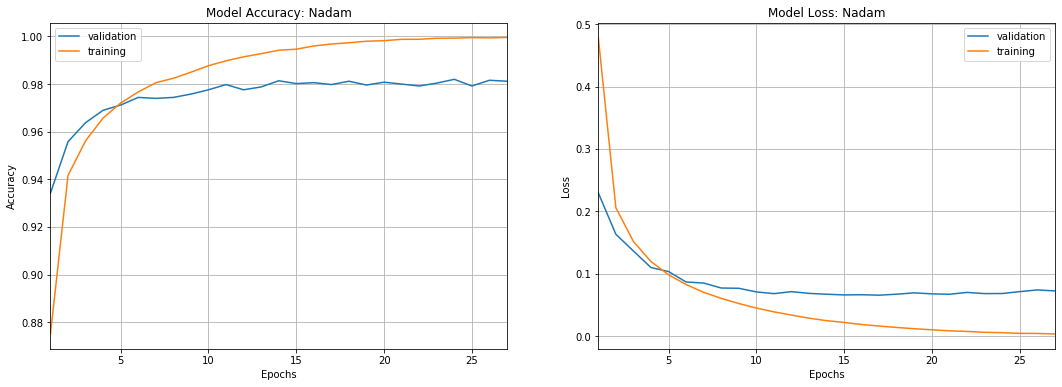

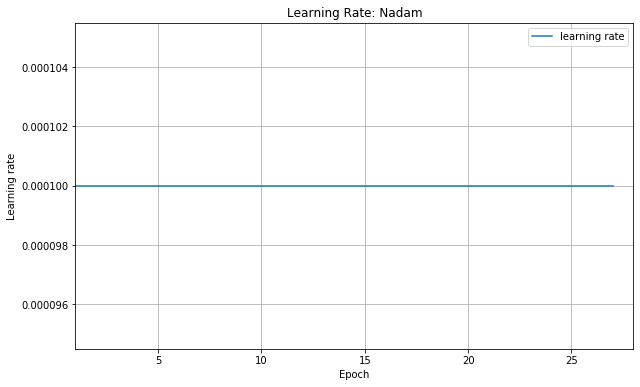

In [87]:
numOfEpochs_Nadam = len(history_Nadam.history['loss'])
print("Epochs: ", numOfEpochs_Nadam )

train_loss_Nadam = model_Nadam.evaluate(X_train, y_train, verbose=0)[0]
train_accuracy_Nadam = model_Nadam.evaluate(X_train, y_train, verbose=0)[1]

test_loss_Nadam = model_Nadam.evaluate(X_test, y_test, verbose=0)[0]
test_accuracy_Nadam = model_Nadam.evaluate(X_test, y_test, verbose=0)[1]

print("Time-based Decay - Train Accuracy: ", train_accuracy_Nadam)
print("Time-based Decay - Test Accuracy: ", test_accuracy_Nadam)

print("\nTime-based Decay - Train Loss: ", train_loss_Nadam)
print("Time-based Decay - Test Loss: ", test_loss_Nadam)


plot_learning_curves(history_Nadam, numOfEpochs_Nadam , "Nadam")

plot_learning_rate(loss_history_Nadam_cb, numOfEpochs_Nadam , "Learning Rate: Nadam")


# Comparison of Validation Accuracy Over Epochs

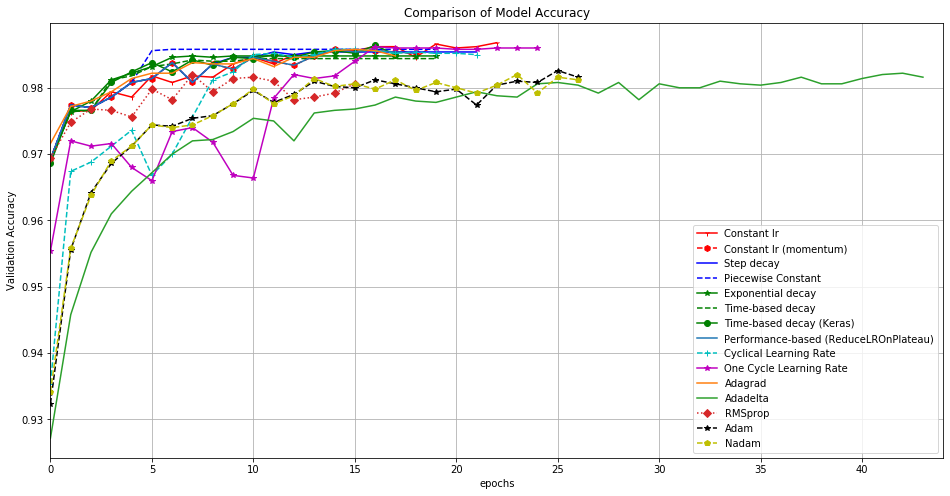

In [88]:
epochs = max(numOfEpochs_constant_lrate, numOfEpochs_constant_lrate_momentum,
             numOfEpochs_step_decay, numOfEpochs_piecewise_constant,
             numOfEpochs_exp_decay, numOfEpochs_time_based_decay, numOfEpochs_time_based_decay_keras,
             numOfEpochs_ReduceLROnPlateau, numOfEpochs_clr, numOfEpochs_oneCycle,
             numOfEpochs_Adagrad, numOfEpochs_Adadelta, numOfEpochs_RMSprop, numOfEpochs_Adam, numOfEpochs_Nadam)

plt.figure(figsize=(16,8))
plt.plot(range(numOfEpochs_constant_lrate),history_constant_lrate.history['val_accuracy'],'r1-',
         label='Constant lr')
plt.plot(range(numOfEpochs_constant_lrate_momentum),history_constant_lrate_momentum.history['val_accuracy'], 'rh--',
         label='Constant lr (momentum)')
plt.plot(range(numOfEpochs_step_decay),history_step_decay.history['val_accuracy'],'b-', label='Step decay')
plt.plot(range(numOfEpochs_piecewise_constant),history_piecewise_constant.history['val_accuracy'], 'b--',
         label='Piecewise Constant')
plt.plot(range(numOfEpochs_exp_decay),history_exp_decay.history['val_accuracy'],'g*-', label='Exponential decay')
plt.plot(range(numOfEpochs_time_based_decay),history_time_based_decay.history['val_accuracy'], 'g--',
         label='Time-based decay')
plt.plot(range(numOfEpochs_time_based_decay_keras),history_time_based_decay_keras.history['val_accuracy'],'go-',
         label='Time-based decay (Keras)')
plt.plot(range(numOfEpochs_ReduceLROnPlateau),history_ReduceLROnPlateau.history['val_accuracy'],label='Performance-based (ReduceLROnPlateau)')
plt.plot(range(numOfEpochs_clr),history_clr.history['val_accuracy'], 'c+--', label='Cyclical Learning Rate')

plt.plot(range(numOfEpochs_oneCycle),history_oneCycle.history['val_accuracy'],'m*-',
         label='One Cycle Learning Rate')
plt.plot(range(numOfEpochs_Adagrad),history_Adagrad.history['val_accuracy'],label='Adagrad')

plt.plot(range(numOfEpochs_Adadelta),history_Adadelta.history['val_accuracy'],label='Adadelta')
plt.plot(range(numOfEpochs_RMSprop),history_RMSprop.history['val_accuracy'], 'D:', label='RMSprop')
plt.plot(range(numOfEpochs_Adam),history_Adam.history['val_accuracy'],'k*--', label='Adam')
plt.plot(range(numOfEpochs_Nadam),history_Nadam.history['val_accuracy'],'yp--', label='Nadam')
plt.legend(loc=0)
plt.xlabel('epochs')
plt.xlim([0,epochs])
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.title("Comparison of Model Accuracy")
plt.show()


# Comparison of Test Accuracy and Total Number of Epochs

In [89]:
data = [
    ["SGD Const. Learning Rate", numOfEpochs_constant_lrate, test_accuracy_constant_lrate],
    ["SGD Const. Learning Rate (momentum)", numOfEpochs_constant_lrate_momentum, test_accuracy_constant_lrate_momentum],
    ["SGD Step Decay", numOfEpochs_step_decay, test_accuracy_step_decay],
    ["SGD Piecewise Constant", numOfEpochs_piecewise_constant, test_accuracy_piecewise_constant],
    ["SGD Exponential Decay", numOfEpochs_exp_decay, test_accuracy_exp_decay],
    ["SGD Time-based Decay", numOfEpochs_time_based_decay, test_accuracy_time_based_decay],
    ["SGD Time-based Decay (Keras)", numOfEpochs_time_based_decay_keras, test_accuracy_time_based_decay_keras],
    ["SGD ReduceLROnPlateau", numOfEpochs_ReduceLROnPlateau, test_accuracy_ReduceLROnPlateau],
    ["SGD Cyclical Learning Rate", numOfEpochs_clr, test_accuracy_clr],
    ["SGD One Cycle Learning Rate", numOfEpochs_oneCycle, test_accuracy_oneCycle],
    ["Adagrad", numOfEpochs_Adagrad, test_accuracy_Adagrad],
    ["Adadelta", numOfEpochs_Adadelta, test_accuracy_Adadelta],
    ["RMSprop", numOfEpochs_RMSprop, test_accuracy_RMSprop],
    ["Adam", numOfEpochs_Adam, test_accuracy_Adam],
    ["NAdam", numOfEpochs_Nadam, test_accuracy_Nadam]
       ]
pd.DataFrame(data, columns=["Name", "Epochs", "Test Accuracy"])

,Name,Epochs,Test Accuracy
0,SGD Const. Learning Rate,23,0.9813
1,SGD Const. Learning Rate (momentum),19,0.9832
2,SGD Step Decay,22,0.9843
3,SGD Piecewise Constant,20,0.9814
4,SGD Exponential Decay,20,0.9812
5,SGD Time-based Decay,20,0.9818
6,SGD Time-based Decay (Keras),18,0.9815
7,SGD ReduceLROnPlateau,19,0.9832
8,SGD Cyclical Learning Rate,22,0.9842
9,SGD One Cycle Learning Rate,25,0.9855


# Overall Observation

We see that overall the **learning schedule** based approach converges faster than the **adaptive learning rate** (fast optimizer) approach for the MNIST dataset.

- The SGD with 1cycle learning schedule provides the higest test accuracy within 29 epochs. The second highest test accuracy comes from SGD (using momentum) with **step decay** learning schedule within 22 epochs.

        In general, we should first try 1cycle (both learning rate and momentum), and then exponential decay schedule with momentum (because it has just one hyperparameter to tune). Following paper provides a comparative analysis of the main learning schedule techniques. 
        https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/40808.pdf

- The **Adagrad** performs better than other adaptive learning rate algorithms.

        In practice, the GOTO fast optimizer should be Adam/Nadam, RMSProp.

